# **Generative Adversarial Network**

Name : Rendra Dwi prasetyo

NIM  : 2602199960

## Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline
import tensorflow

In [ ]:
# check version of tensorflow
print (tensorflow.__version__)

2.15.0


## Dataset

11490434/11490434 [==============================] - 0s 0us/step
Training data shapes: X=(60000, 28, 28), y=(60000,)
Testing data shapes: X=(10000, 28, 28), y=(10000,)


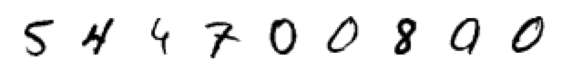

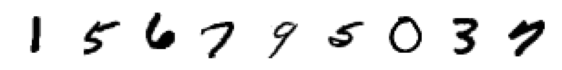

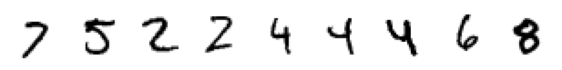

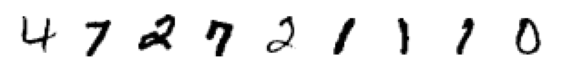

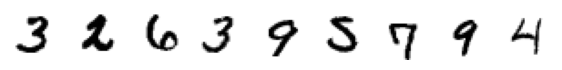

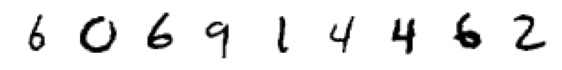

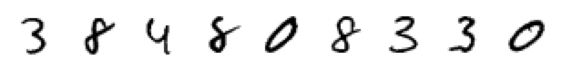

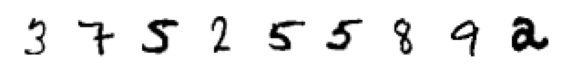

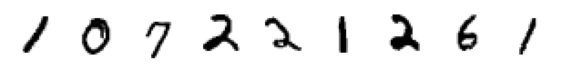

In [ ]:
# Import dataset fashion_mnist and mnist from tensorflow
from tensorflow.keras.datasets import fashion_mnist, mnist

(trainX, trainY), (testX, testY) = mnist.load_data()

# Data training
print('Training data shapes: X=%s, y=%s' % (trainX.shape, trainY.shape))

# Data testing
print('Testing data shapes: X=%s, y=%s' % (testX.shape, testY.shape))

# display image
for k in range(9):
    plt.figure(figsize=(7, 7))
    for j in range(9):
        i = np.random.randint(0, 10000)
        plt.subplot(990 + 1 + j)
        plt.imshow(trainX[i], cmap='gray_r')
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

## Normalization

In [ ]:
trainX = [image/255.0 for image in trainX]
testX = [image/255.0 for image in testX]

trainX = np.reshape(trainX, (60000, 28, 28, 1))
testX = np.reshape(testX, (10000, 28, 28, 1))

print (trainX.shape, testX.shape, trainY.shape, testY.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1) (60000,) (10000,)


## **Generator Network**

Some of the **settings** on the generator that I made are:
1. Increase network complexity by **maximizing the number of units in the Dense layer** 2048 and 1024 to increase the model's capacity to produce more detailed data representation.
2. Using **LeakyReLU** as additional activation:
Add a LeakyReLU layer after the Dense layer with parameter alpha=0.2 to prevent the problem of dying neurons which often occurs in ReLU.
3. Place Batch Normalization after LeakyReLU to keep the output distribution stable during training.

In [ ]:
from tensorflow.keras import layers, models, regularizers

In [ ]:
random_input = tensorflow.keras.layers.Input(shape =(50, ))

x = tensorflow.keras.layers.Dense(2048, activation='relu')(random_input)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Dense(1024, activation='relu')(x)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

x = tensorflow.keras.layers.Dense(28*28)(x)
x = tensorflow.keras.layers.Reshape((28, 28, 1))(x)

generated_image = tensorflow.keras.layers.Activation('sigmoid')(x)

generator_network = tensorflow.keras.models.Model(inputs=random_input, outputs=generated_image)
generator_network.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 dense (Dense)               (None, 2048)              104448    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 2048)              0         
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 1024)              0         
                                                             

## **Discriminator Network**

Some of the **settings** in the Discriminator that I made are:
1. Added L2 regulation (kernel_regularizer):
  - Provides a penalty on the Dense layer weights to prevent overfitting, with an L2 regulation parameter of 0.01.

2. Maintain dropout for generalization:
  - Continue to use Dropout with a ratio of 0.3 and 0.5 on the Dense layer to reduce the risk of overfitting.

3. Using Adam optimizer:
  - Tuned the optimizer with Adam using parameters learning_rate=0.0002 and beta_1=0.5 for more stable and efficient weight updates.

In [ ]:
image_input = layers.Input(shape=(28, 28, 1))

x = layers.Flatten()(image_input)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1)(x)

real_vs_fake_output = layers.Activation('sigmoid')(x)

discriminator_network = models.Model(inputs=image_input, outputs=real_vs_fake_output)
discriminator_network.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
                              loss='binary_crossentropy',
                              metrics=['accuracy'])
discriminator_network.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               200960    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129 

In [ ]:
adam_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.5)
discriminator_network.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])

# GAN, Defining combined model & Compiling GAN

In [ ]:
gan_input = layers.Input(shape=(50,))
generated_image = generator_network(gan_input)
discriminator_network.trainable = False  # Freeze discriminator during GAN training
gan_output = discriminator_network(generated_image)

gan_model = models.Model(inputs=gan_input, outputs=gan_output)
gan_model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.5),
                  loss='binary_crossentropy')
gan_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50)]              0         
                                                                 
 model (Functional)          (None, 28, 28, 1)         3018512   
                                                                 
 model_1 (Functional)        (None, 1)                 233985    
                                                                 
Total params: 3252497 (12.41 MB)
Trainable params: 3012368 (11.49 MB)
Non-trainable params: 240129 (938.00 KB)
_________________________________________________________________


# Compiling GAN

In [ ]:
# gan_model.compile(loss='binary_crossentropy', optimizer=adam_optimizer)

# Define Data Generators

In [ ]:
# Indices of Zero Images
indices = [i for i in range(len(trainX))]

def get_random_noise(batch_size, noise_size):
    random_values = np.random.randn(batch_size*noise_size)
    random_noise_batch = np.reshape(random_values, (batch_size, noise_size))
    return random_noise_batch

def get_fake_samples(generator_network, batch_size, noise_size):
    random_noise_batch = get_random_noise(batch_size, noise_size)
    fake_samples = generator_network.predict_on_batch(random_noise_batch)
    return fake_samples

def get_real_samples(batch_size):
    random_indices = np.random.choice(indices, size=batch_size)
    real_images = trainX[np.array(random_indices),:]
    return real_images

def show_generator_results(generator_network):
    for k in range(9):
        plt.figure(figsize=(7, 7))
        fake_samples = get_fake_samples(generator_network, 9, noise_size)
        for j in range(9):
            plt.subplot(990 + 1 + j)
            plt.imshow(fake_samples[j,:,:,-1], cmap='gray_r')
            plt.axis('off')
            #plt.title(trainY[i])
        plt.show()
    return

# Training GAN

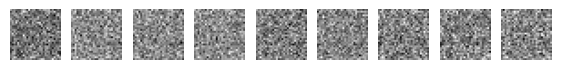

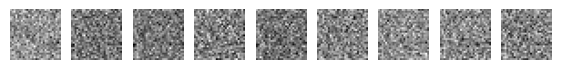

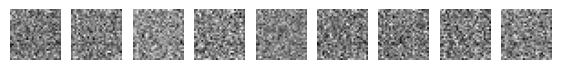

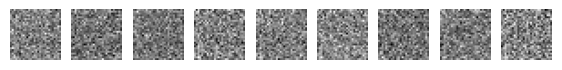

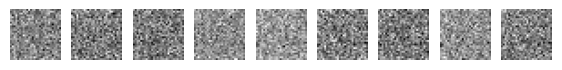

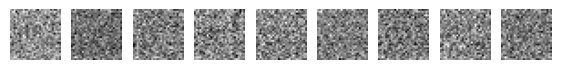

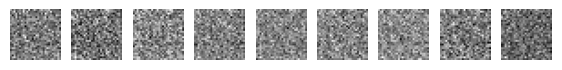

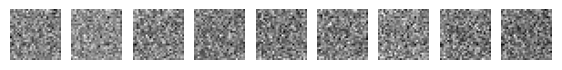

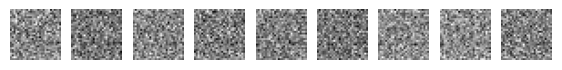

Epoch:0, Step:0, D-Loss:6.328, D-Acc:49.000, G-Loss:6.377
Epoch:0, Step:50, D-Loss:5.627, D-Acc:95.000, G-Loss:8.092
Epoch:0, Step:100, D-Loss:5.222, D-Acc:100.000, G-Loss:9.025
Epoch:0, Step:150, D-Loss:4.912, D-Acc:100.000, G-Loss:9.597
Epoch:0, Step:200, D-Loss:4.642, D-Acc:99.000, G-Loss:9.671
Epoch:0, Step:250, D-Loss:4.353, D-Acc:99.000, G-Loss:10.018
Epoch:0, Step:300, D-Loss:4.099, D-Acc:100.000, G-Loss:10.514
Epoch:0, Step:350, D-Loss:3.875, D-Acc:98.000, G-Loss:10.801
Epoch:1, Step:0, D-Loss:3.643, D-Acc:99.000, G-Loss:11.847
Epoch:1, Step:50, D-Loss:3.427, D-Acc:99.000, G-Loss:11.607
Epoch:1, Step:100, D-Loss:3.301, D-Acc:96.000, G-Loss:12.150
Epoch:1, Step:150, D-Loss:3.109, D-Acc:97.000, G-Loss:11.799
Epoch:1, Step:200, D-Loss:2.949, D-Acc:94.000, G-Loss:10.860
Epoch:1, Step:250, D-Loss:2.812, D-Acc:94.000, G-Loss:10.573
Epoch:1, Step:300, D-Loss:2.643, D-Acc:96.000, G-Loss:9.810
Epoch:1, Step:350, D-Loss:2.484, D-Acc:97.000, G-Loss:8.511
Epoch:2, Step:0, D-Loss:2.380, D-A

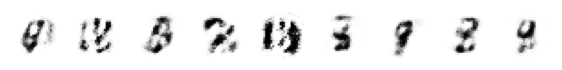

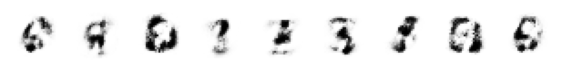

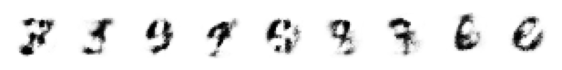

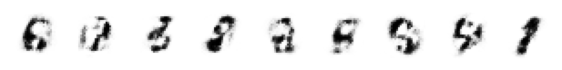

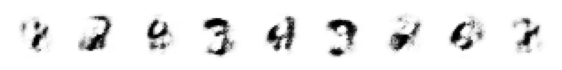

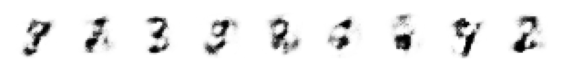

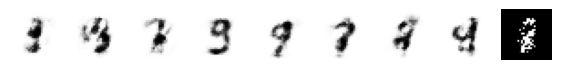

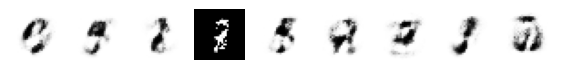

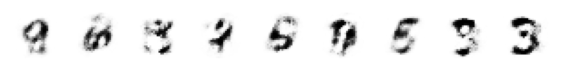

Epoch:10, Step:0, D-Loss:0.649, D-Acc:86.000, G-Loss:1.577
Epoch:10, Step:50, D-Loss:0.653, D-Acc:86.000, G-Loss:1.506
Epoch:10, Step:100, D-Loss:0.654, D-Acc:87.000, G-Loss:1.739
Epoch:10, Step:150, D-Loss:0.707, D-Acc:83.000, G-Loss:1.550
Epoch:10, Step:200, D-Loss:0.666, D-Acc:84.000, G-Loss:1.616
Epoch:10, Step:250, D-Loss:0.655, D-Acc:84.000, G-Loss:1.512
Epoch:10, Step:300, D-Loss:0.672, D-Acc:89.000, G-Loss:1.411
Epoch:10, Step:350, D-Loss:0.636, D-Acc:89.000, G-Loss:1.441
Epoch:11, Step:0, D-Loss:0.646, D-Acc:85.000, G-Loss:1.522
Epoch:11, Step:50, D-Loss:0.677, D-Acc:87.000, G-Loss:1.368
Epoch:11, Step:100, D-Loss:0.686, D-Acc:85.000, G-Loss:1.468
Epoch:11, Step:150, D-Loss:0.656, D-Acc:87.000, G-Loss:1.480
Epoch:11, Step:200, D-Loss:0.732, D-Acc:74.000, G-Loss:1.395
Epoch:11, Step:250, D-Loss:0.668, D-Acc:82.000, G-Loss:1.388
Epoch:11, Step:300, D-Loss:0.682, D-Acc:82.000, G-Loss:1.293
Epoch:11, Step:350, D-Loss:0.662, D-Acc:86.000, G-Loss:1.376
Epoch:12, Step:0, D-Loss:0.631

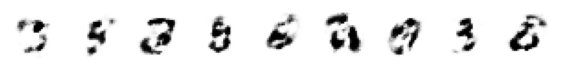

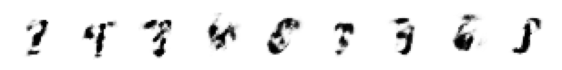

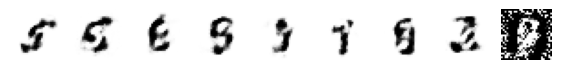

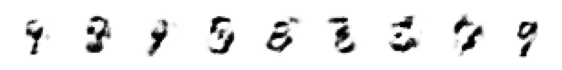

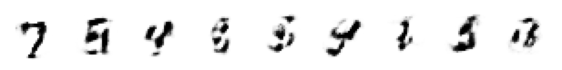

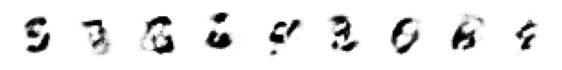

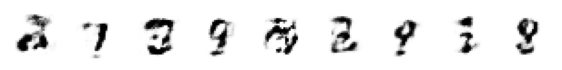

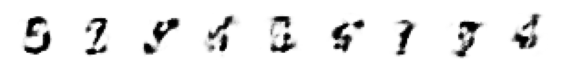

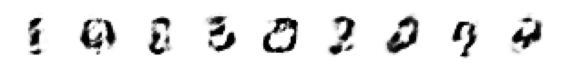

Epoch:20, Step:0, D-Loss:0.612, D-Acc:82.000, G-Loss:1.255
Epoch:20, Step:50, D-Loss:0.675, D-Acc:72.000, G-Loss:1.168
Epoch:20, Step:100, D-Loss:0.679, D-Acc:77.000, G-Loss:1.169
Epoch:20, Step:150, D-Loss:0.673, D-Acc:77.000, G-Loss:1.175
Epoch:20, Step:200, D-Loss:0.682, D-Acc:76.000, G-Loss:1.283
Epoch:20, Step:250, D-Loss:0.623, D-Acc:82.000, G-Loss:1.198
Epoch:20, Step:300, D-Loss:0.649, D-Acc:79.000, G-Loss:1.248
Epoch:20, Step:350, D-Loss:0.654, D-Acc:82.000, G-Loss:1.167
Epoch:21, Step:0, D-Loss:0.657, D-Acc:80.000, G-Loss:1.230
Epoch:21, Step:50, D-Loss:0.675, D-Acc:77.000, G-Loss:1.180
Epoch:21, Step:100, D-Loss:0.678, D-Acc:73.000, G-Loss:1.105
Epoch:21, Step:150, D-Loss:0.700, D-Acc:70.000, G-Loss:1.185
Epoch:21, Step:200, D-Loss:0.668, D-Acc:76.000, G-Loss:1.161
Epoch:21, Step:250, D-Loss:0.663, D-Acc:80.000, G-Loss:1.190
Epoch:21, Step:300, D-Loss:0.671, D-Acc:80.000, G-Loss:1.102
Epoch:21, Step:350, D-Loss:0.728, D-Acc:70.000, G-Loss:1.155
Epoch:22, Step:0, D-Loss:0.652

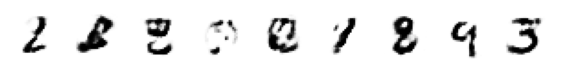

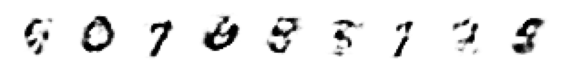

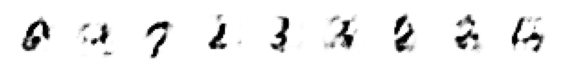

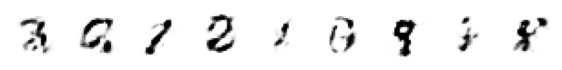

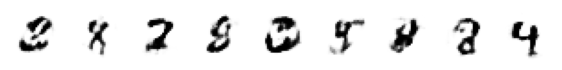

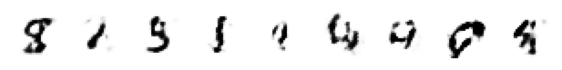

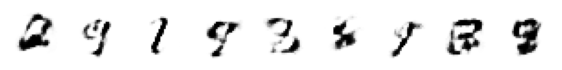

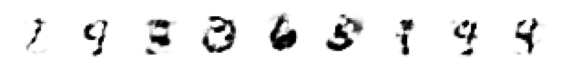

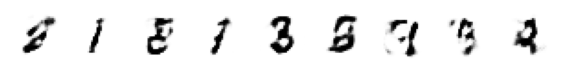

Epoch:30, Step:0, D-Loss:0.695, D-Acc:69.000, G-Loss:0.992
Epoch:30, Step:50, D-Loss:0.667, D-Acc:78.000, G-Loss:1.070
Epoch:30, Step:100, D-Loss:0.686, D-Acc:72.000, G-Loss:0.990
Epoch:30, Step:150, D-Loss:0.723, D-Acc:67.000, G-Loss:1.010
Epoch:30, Step:200, D-Loss:0.721, D-Acc:69.000, G-Loss:0.959
Epoch:30, Step:250, D-Loss:0.669, D-Acc:70.000, G-Loss:0.984
Epoch:30, Step:300, D-Loss:0.693, D-Acc:69.000, G-Loss:1.037
Epoch:30, Step:350, D-Loss:0.680, D-Acc:73.000, G-Loss:0.995
Epoch:31, Step:0, D-Loss:0.695, D-Acc:74.000, G-Loss:0.997
Epoch:31, Step:50, D-Loss:0.664, D-Acc:74.000, G-Loss:1.012
Epoch:31, Step:100, D-Loss:0.737, D-Acc:60.000, G-Loss:1.015
Epoch:31, Step:150, D-Loss:0.706, D-Acc:67.000, G-Loss:1.032
Epoch:31, Step:200, D-Loss:0.727, D-Acc:68.000, G-Loss:1.055
Epoch:31, Step:250, D-Loss:0.683, D-Acc:71.000, G-Loss:0.937
Epoch:31, Step:300, D-Loss:0.687, D-Acc:68.000, G-Loss:0.963
Epoch:31, Step:350, D-Loss:0.681, D-Acc:71.000, G-Loss:0.989
Epoch:32, Step:0, D-Loss:0.669

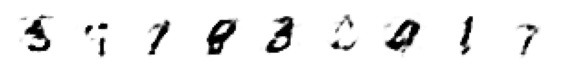

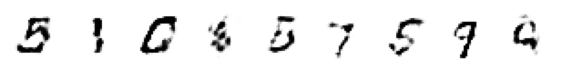

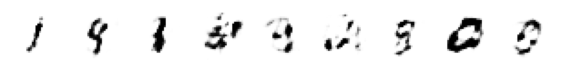

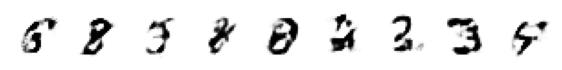

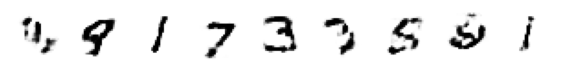

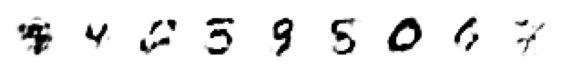

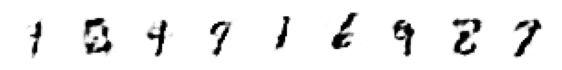

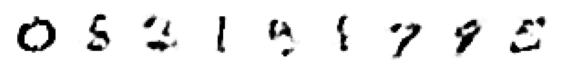

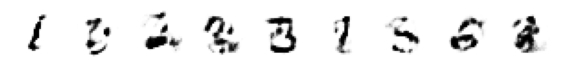

Epoch:40, Step:0, D-Loss:0.705, D-Acc:66.000, G-Loss:0.932
Epoch:40, Step:50, D-Loss:0.690, D-Acc:66.000, G-Loss:0.953
Epoch:40, Step:100, D-Loss:0.658, D-Acc:71.000, G-Loss:0.922
Epoch:40, Step:150, D-Loss:0.702, D-Acc:69.000, G-Loss:0.919
Epoch:40, Step:200, D-Loss:0.722, D-Acc:69.000, G-Loss:0.952
Epoch:40, Step:250, D-Loss:0.669, D-Acc:77.000, G-Loss:0.878
Epoch:40, Step:300, D-Loss:0.736, D-Acc:60.000, G-Loss:0.924
Epoch:40, Step:350, D-Loss:0.707, D-Acc:68.000, G-Loss:0.897
Epoch:41, Step:0, D-Loss:0.703, D-Acc:66.000, G-Loss:0.869
Epoch:41, Step:50, D-Loss:0.684, D-Acc:78.000, G-Loss:0.971
Epoch:41, Step:100, D-Loss:0.683, D-Acc:69.000, G-Loss:0.919
Epoch:41, Step:150, D-Loss:0.721, D-Acc:63.000, G-Loss:0.948
Epoch:41, Step:200, D-Loss:0.656, D-Acc:80.000, G-Loss:0.930
Epoch:41, Step:250, D-Loss:0.709, D-Acc:70.000, G-Loss:0.998
Epoch:41, Step:300, D-Loss:0.679, D-Acc:64.000, G-Loss:0.917
Epoch:41, Step:350, D-Loss:0.712, D-Acc:68.000, G-Loss:0.929
Epoch:42, Step:0, D-Loss:0.689

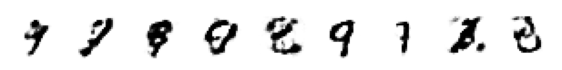

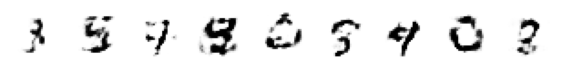

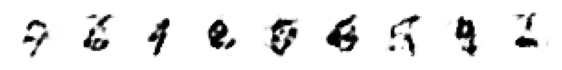

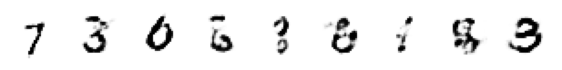

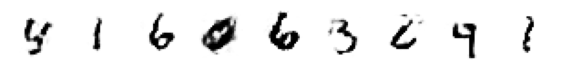

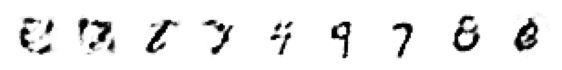

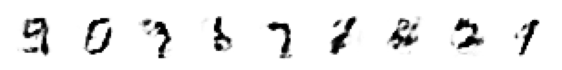

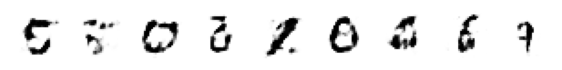

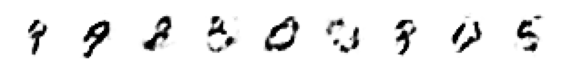

Epoch:50, Step:0, D-Loss:0.666, D-Acc:69.000, G-Loss:0.879
Epoch:50, Step:50, D-Loss:0.711, D-Acc:63.000, G-Loss:0.898
Epoch:50, Step:100, D-Loss:0.663, D-Acc:78.000, G-Loss:0.847
Epoch:50, Step:150, D-Loss:0.688, D-Acc:73.000, G-Loss:0.873
Epoch:50, Step:200, D-Loss:0.711, D-Acc:63.000, G-Loss:0.892
Epoch:50, Step:250, D-Loss:0.674, D-Acc:73.000, G-Loss:0.876
Epoch:50, Step:300, D-Loss:0.668, D-Acc:75.000, G-Loss:0.933
Epoch:50, Step:350, D-Loss:0.643, D-Acc:74.000, G-Loss:0.872
Epoch:51, Step:0, D-Loss:0.694, D-Acc:66.000, G-Loss:0.925
Epoch:51, Step:50, D-Loss:0.726, D-Acc:67.000, G-Loss:0.878
Epoch:51, Step:100, D-Loss:0.701, D-Acc:66.000, G-Loss:0.920
Epoch:51, Step:150, D-Loss:0.710, D-Acc:61.000, G-Loss:0.901
Epoch:51, Step:200, D-Loss:0.678, D-Acc:71.000, G-Loss:0.865
Epoch:51, Step:250, D-Loss:0.733, D-Acc:62.000, G-Loss:0.919
Epoch:51, Step:300, D-Loss:0.647, D-Acc:78.000, G-Loss:0.925
Epoch:51, Step:350, D-Loss:0.688, D-Acc:69.000, G-Loss:0.879
Epoch:52, Step:0, D-Loss:0.657

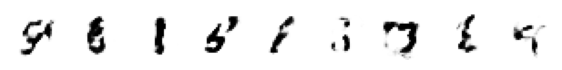

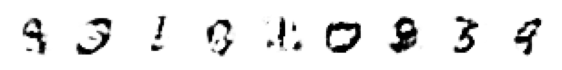

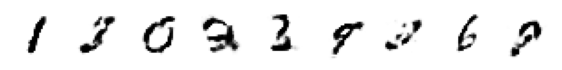

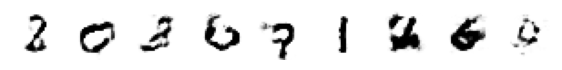

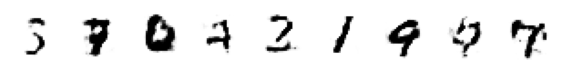

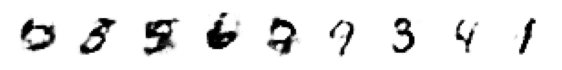

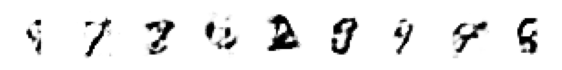

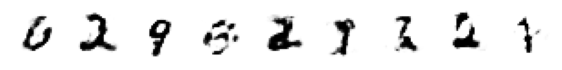

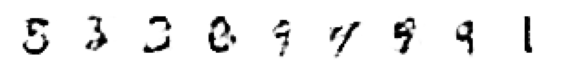

Epoch:60, Step:0, D-Loss:0.678, D-Acc:65.000, G-Loss:0.881
Epoch:60, Step:50, D-Loss:0.712, D-Acc:64.000, G-Loss:0.850
Epoch:60, Step:100, D-Loss:0.703, D-Acc:66.000, G-Loss:0.858
Epoch:60, Step:150, D-Loss:0.682, D-Acc:72.000, G-Loss:0.868
Epoch:60, Step:200, D-Loss:0.690, D-Acc:70.000, G-Loss:0.852
Epoch:60, Step:250, D-Loss:0.695, D-Acc:63.000, G-Loss:0.854
Epoch:60, Step:300, D-Loss:0.719, D-Acc:62.000, G-Loss:0.840
Epoch:60, Step:350, D-Loss:0.684, D-Acc:67.000, G-Loss:0.859
Epoch:61, Step:0, D-Loss:0.701, D-Acc:70.000, G-Loss:0.869
Epoch:61, Step:50, D-Loss:0.689, D-Acc:70.000, G-Loss:0.884
Epoch:61, Step:100, D-Loss:0.675, D-Acc:68.000, G-Loss:0.853
Epoch:61, Step:150, D-Loss:0.683, D-Acc:71.000, G-Loss:0.884
Epoch:61, Step:200, D-Loss:0.684, D-Acc:66.000, G-Loss:0.846
Epoch:61, Step:250, D-Loss:0.706, D-Acc:64.000, G-Loss:0.881
Epoch:61, Step:300, D-Loss:0.696, D-Acc:64.000, G-Loss:0.872
Epoch:61, Step:350, D-Loss:0.662, D-Acc:65.000, G-Loss:0.816
Epoch:62, Step:0, D-Loss:0.704

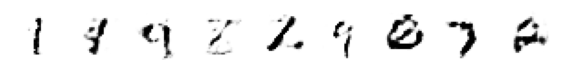

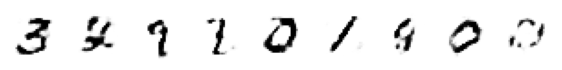

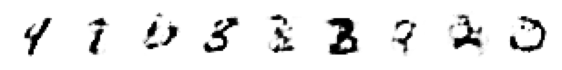

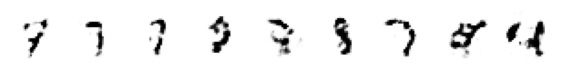

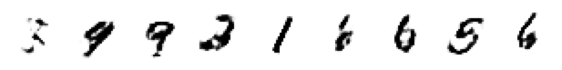

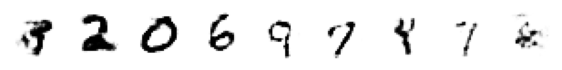

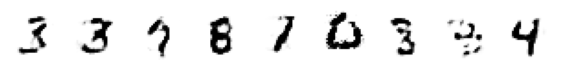

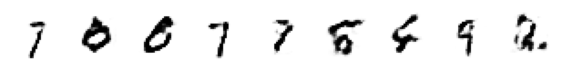

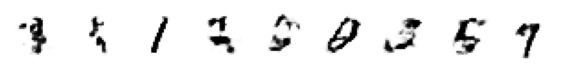

Epoch:70, Step:0, D-Loss:0.676, D-Acc:70.000, G-Loss:0.870
Epoch:70, Step:50, D-Loss:0.675, D-Acc:64.000, G-Loss:0.813
Epoch:70, Step:100, D-Loss:0.676, D-Acc:70.000, G-Loss:0.832
Epoch:70, Step:150, D-Loss:0.683, D-Acc:72.000, G-Loss:0.824
Epoch:70, Step:200, D-Loss:0.683, D-Acc:70.000, G-Loss:0.805
Epoch:70, Step:250, D-Loss:0.694, D-Acc:75.000, G-Loss:0.803
Epoch:70, Step:300, D-Loss:0.688, D-Acc:75.000, G-Loss:0.827
Epoch:70, Step:350, D-Loss:0.713, D-Acc:62.000, G-Loss:0.840
Epoch:71, Step:0, D-Loss:0.678, D-Acc:70.000, G-Loss:0.834
Epoch:71, Step:50, D-Loss:0.714, D-Acc:62.000, G-Loss:0.797
Epoch:71, Step:100, D-Loss:0.719, D-Acc:61.000, G-Loss:0.837
Epoch:71, Step:150, D-Loss:0.695, D-Acc:67.000, G-Loss:0.828
Epoch:71, Step:200, D-Loss:0.700, D-Acc:63.000, G-Loss:0.824
Epoch:71, Step:250, D-Loss:0.688, D-Acc:68.000, G-Loss:0.825
Epoch:71, Step:300, D-Loss:0.678, D-Acc:73.000, G-Loss:0.806
Epoch:71, Step:350, D-Loss:0.708, D-Acc:65.000, G-Loss:0.851
Epoch:72, Step:0, D-Loss:0.680

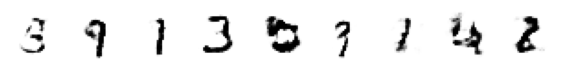

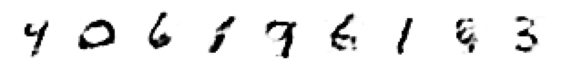

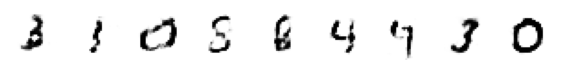

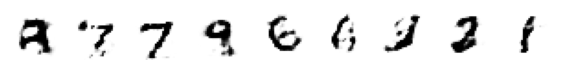

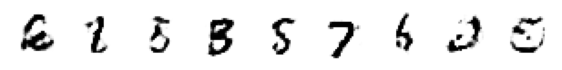

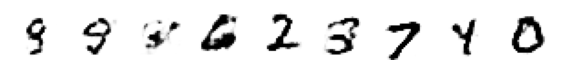

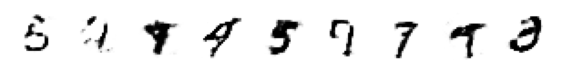

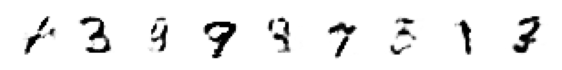

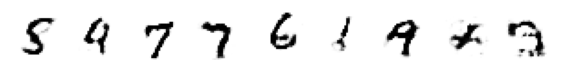

Epoch:80, Step:0, D-Loss:0.705, D-Acc:59.000, G-Loss:0.811
Epoch:80, Step:50, D-Loss:0.687, D-Acc:59.000, G-Loss:0.792
Epoch:80, Step:100, D-Loss:0.693, D-Acc:61.000, G-Loss:0.804
Epoch:80, Step:150, D-Loss:0.686, D-Acc:66.000, G-Loss:0.808
Epoch:80, Step:200, D-Loss:0.701, D-Acc:68.000, G-Loss:0.818
Epoch:80, Step:250, D-Loss:0.705, D-Acc:60.000, G-Loss:0.832
Epoch:80, Step:300, D-Loss:0.701, D-Acc:61.000, G-Loss:0.841
Epoch:80, Step:350, D-Loss:0.690, D-Acc:63.000, G-Loss:0.816
Epoch:81, Step:0, D-Loss:0.682, D-Acc:63.000, G-Loss:0.832
Epoch:81, Step:50, D-Loss:0.721, D-Acc:63.000, G-Loss:0.813
Epoch:81, Step:100, D-Loss:0.668, D-Acc:71.000, G-Loss:0.857
Epoch:81, Step:150, D-Loss:0.700, D-Acc:62.000, G-Loss:0.804
Epoch:81, Step:200, D-Loss:0.702, D-Acc:61.000, G-Loss:0.787
Epoch:81, Step:250, D-Loss:0.710, D-Acc:62.000, G-Loss:0.826
Epoch:81, Step:300, D-Loss:0.713, D-Acc:61.000, G-Loss:0.771
Epoch:81, Step:350, D-Loss:0.674, D-Acc:70.000, G-Loss:0.805
Epoch:82, Step:0, D-Loss:0.670

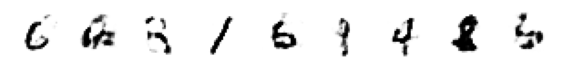

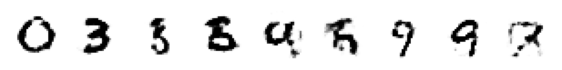

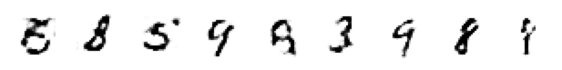

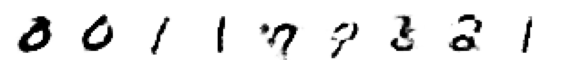

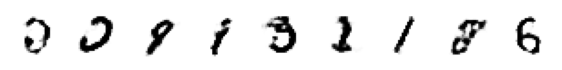

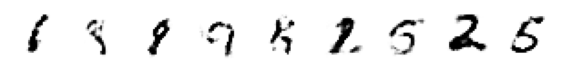

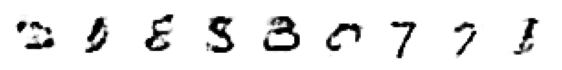

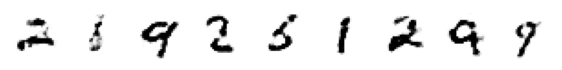

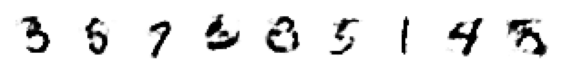

Epoch:90, Step:0, D-Loss:0.725, D-Acc:55.000, G-Loss:0.811
Epoch:90, Step:50, D-Loss:0.701, D-Acc:60.000, G-Loss:0.805
Epoch:90, Step:100, D-Loss:0.687, D-Acc:66.000, G-Loss:0.798
Epoch:90, Step:150, D-Loss:0.676, D-Acc:74.000, G-Loss:0.813
Epoch:90, Step:200, D-Loss:0.695, D-Acc:64.000, G-Loss:0.811
Epoch:90, Step:250, D-Loss:0.720, D-Acc:54.000, G-Loss:0.825
Epoch:90, Step:300, D-Loss:0.670, D-Acc:68.000, G-Loss:0.811
Epoch:90, Step:350, D-Loss:0.693, D-Acc:64.000, G-Loss:0.772
Epoch:91, Step:0, D-Loss:0.695, D-Acc:67.000, G-Loss:0.822
Epoch:91, Step:50, D-Loss:0.697, D-Acc:61.000, G-Loss:0.782
Epoch:91, Step:100, D-Loss:0.689, D-Acc:66.000, G-Loss:0.785
Epoch:91, Step:150, D-Loss:0.691, D-Acc:59.000, G-Loss:0.804
Epoch:91, Step:200, D-Loss:0.701, D-Acc:57.000, G-Loss:0.787
Epoch:91, Step:250, D-Loss:0.671, D-Acc:64.000, G-Loss:0.846
Epoch:91, Step:300, D-Loss:0.707, D-Acc:62.000, G-Loss:0.813
Epoch:91, Step:350, D-Loss:0.705, D-Acc:61.000, G-Loss:0.811
Epoch:92, Step:0, D-Loss:0.692

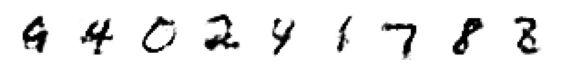

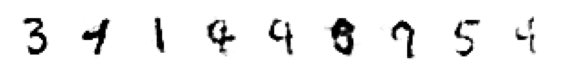

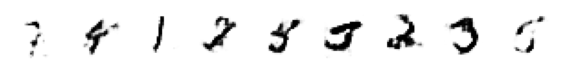

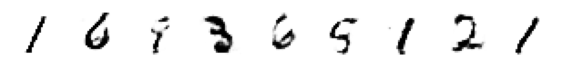

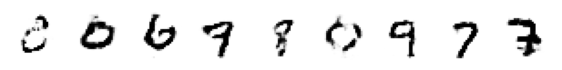

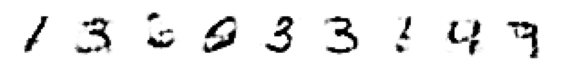

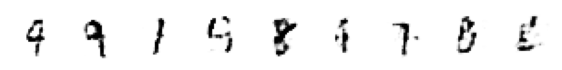

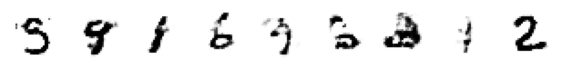

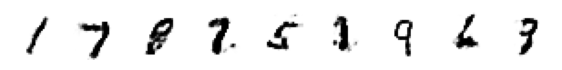

Epoch:100, Step:0, D-Loss:0.679, D-Acc:64.000, G-Loss:0.815
Epoch:100, Step:50, D-Loss:0.716, D-Acc:57.000, G-Loss:0.788
Epoch:100, Step:100, D-Loss:0.701, D-Acc:58.000, G-Loss:0.814
Epoch:100, Step:150, D-Loss:0.708, D-Acc:62.000, G-Loss:0.803
Epoch:100, Step:200, D-Loss:0.694, D-Acc:63.000, G-Loss:0.791
Epoch:100, Step:250, D-Loss:0.703, D-Acc:63.000, G-Loss:0.782
Epoch:100, Step:300, D-Loss:0.703, D-Acc:58.000, G-Loss:0.789
Epoch:100, Step:350, D-Loss:0.682, D-Acc:71.000, G-Loss:0.811
Epoch:101, Step:0, D-Loss:0.718, D-Acc:66.000, G-Loss:0.790
Epoch:101, Step:50, D-Loss:0.693, D-Acc:65.000, G-Loss:0.745
Epoch:101, Step:100, D-Loss:0.693, D-Acc:65.000, G-Loss:0.770
Epoch:101, Step:150, D-Loss:0.703, D-Acc:60.000, G-Loss:0.789
Epoch:101, Step:200, D-Loss:0.692, D-Acc:61.000, G-Loss:0.783
Epoch:101, Step:250, D-Loss:0.708, D-Acc:62.000, G-Loss:0.780
Epoch:101, Step:300, D-Loss:0.685, D-Acc:62.000, G-Loss:0.802
Epoch:102, Step:0, D-Loss:0.704, D-Acc:61.000, G-Loss:0.807
Epoch:102, Step:

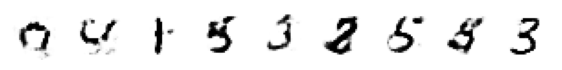

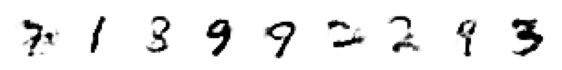

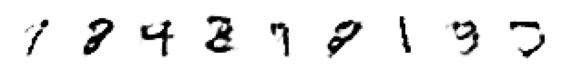

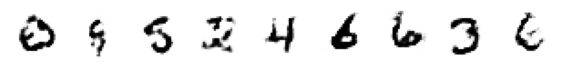

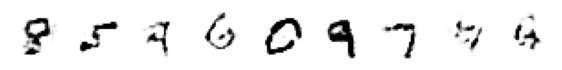

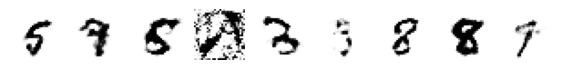

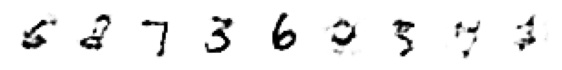

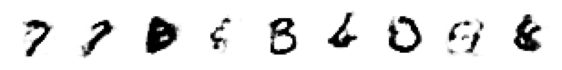

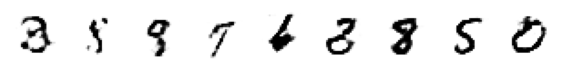

Epoch:110, Step:0, D-Loss:0.698, D-Acc:66.000, G-Loss:0.804
Epoch:110, Step:50, D-Loss:0.689, D-Acc:67.000, G-Loss:0.755
Epoch:110, Step:100, D-Loss:0.676, D-Acc:69.000, G-Loss:0.802
Epoch:110, Step:150, D-Loss:0.701, D-Acc:61.000, G-Loss:0.801
Epoch:110, Step:200, D-Loss:0.667, D-Acc:68.000, G-Loss:0.818
Epoch:110, Step:250, D-Loss:0.708, D-Acc:58.000, G-Loss:0.807
Epoch:110, Step:300, D-Loss:0.702, D-Acc:61.000, G-Loss:0.795
Epoch:110, Step:350, D-Loss:0.704, D-Acc:59.000, G-Loss:0.777
Epoch:111, Step:0, D-Loss:0.711, D-Acc:61.000, G-Loss:0.774
Epoch:111, Step:50, D-Loss:0.704, D-Acc:66.000, G-Loss:0.802
Epoch:111, Step:100, D-Loss:0.695, D-Acc:66.000, G-Loss:0.805
Epoch:111, Step:150, D-Loss:0.704, D-Acc:68.000, G-Loss:0.843
Epoch:111, Step:200, D-Loss:0.685, D-Acc:66.000, G-Loss:0.794
Epoch:111, Step:250, D-Loss:0.684, D-Acc:69.000, G-Loss:0.826
Epoch:111, Step:300, D-Loss:0.693, D-Acc:66.000, G-Loss:0.801
Epoch:111, Step:350, D-Loss:0.662, D-Acc:73.000, G-Loss:0.815
Epoch:112, Ste

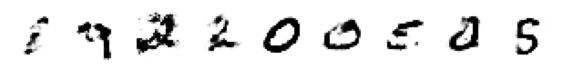

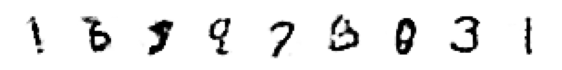

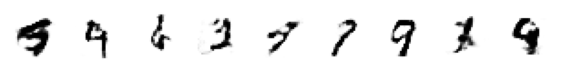

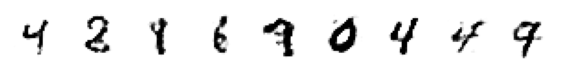

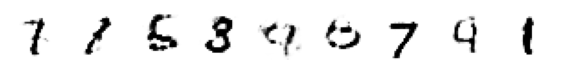

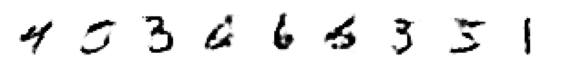

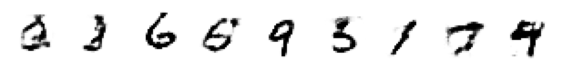

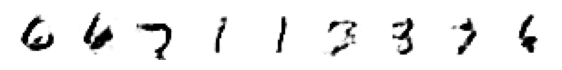

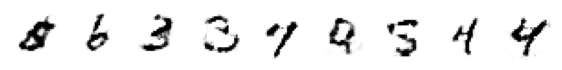

Epoch:120, Step:0, D-Loss:0.708, D-Acc:60.000, G-Loss:0.777
Epoch:120, Step:50, D-Loss:0.683, D-Acc:68.000, G-Loss:0.800
Epoch:120, Step:100, D-Loss:0.692, D-Acc:66.000, G-Loss:0.754
Epoch:120, Step:150, D-Loss:0.690, D-Acc:63.000, G-Loss:0.789
Epoch:120, Step:200, D-Loss:0.707, D-Acc:64.000, G-Loss:0.785
Epoch:120, Step:250, D-Loss:0.696, D-Acc:64.000, G-Loss:0.811
Epoch:120, Step:300, D-Loss:0.682, D-Acc:59.000, G-Loss:0.788
Epoch:120, Step:350, D-Loss:0.675, D-Acc:67.000, G-Loss:0.814
Epoch:121, Step:0, D-Loss:0.682, D-Acc:68.000, G-Loss:0.821
Epoch:121, Step:50, D-Loss:0.678, D-Acc:64.000, G-Loss:0.817
Epoch:121, Step:100, D-Loss:0.695, D-Acc:66.000, G-Loss:0.785
Epoch:121, Step:150, D-Loss:0.696, D-Acc:64.000, G-Loss:0.784
Epoch:121, Step:200, D-Loss:0.710, D-Acc:62.000, G-Loss:0.795
Epoch:121, Step:250, D-Loss:0.718, D-Acc:55.000, G-Loss:0.793
Epoch:121, Step:300, D-Loss:0.688, D-Acc:64.000, G-Loss:0.798
Epoch:121, Step:350, D-Loss:0.712, D-Acc:60.000, G-Loss:0.812
Epoch:122, Ste

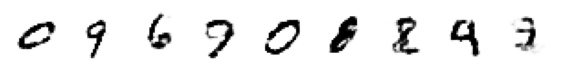

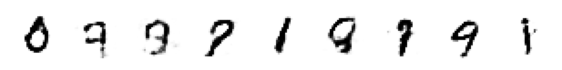

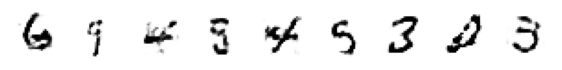

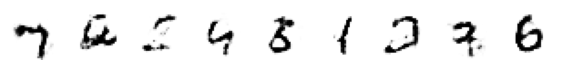

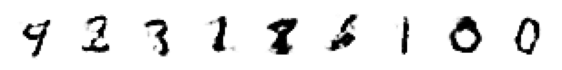

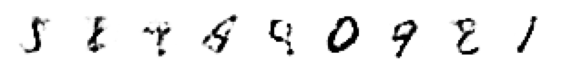

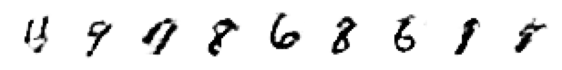

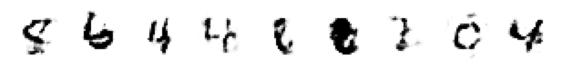

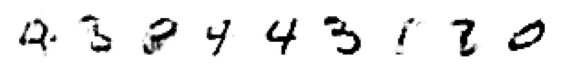

Epoch:130, Step:0, D-Loss:0.679, D-Acc:66.000, G-Loss:0.783
Epoch:130, Step:50, D-Loss:0.739, D-Acc:53.000, G-Loss:0.820
Epoch:130, Step:100, D-Loss:0.707, D-Acc:67.000, G-Loss:0.799
Epoch:130, Step:150, D-Loss:0.685, D-Acc:62.000, G-Loss:0.794
Epoch:130, Step:200, D-Loss:0.682, D-Acc:63.000, G-Loss:0.833
Epoch:130, Step:250, D-Loss:0.710, D-Acc:61.000, G-Loss:0.782
Epoch:130, Step:300, D-Loss:0.691, D-Acc:64.000, G-Loss:0.791
Epoch:130, Step:350, D-Loss:0.680, D-Acc:64.000, G-Loss:0.776
Epoch:131, Step:0, D-Loss:0.686, D-Acc:68.000, G-Loss:0.796
Epoch:131, Step:50, D-Loss:0.701, D-Acc:62.000, G-Loss:0.806
Epoch:131, Step:100, D-Loss:0.676, D-Acc:67.000, G-Loss:0.773
Epoch:131, Step:150, D-Loss:0.686, D-Acc:68.000, G-Loss:0.787
Epoch:131, Step:200, D-Loss:0.692, D-Acc:63.000, G-Loss:0.792
Epoch:131, Step:250, D-Loss:0.693, D-Acc:59.000, G-Loss:0.782
Epoch:131, Step:300, D-Loss:0.683, D-Acc:68.000, G-Loss:0.808
Epoch:131, Step:350, D-Loss:0.683, D-Acc:69.000, G-Loss:0.801
Epoch:132, Ste

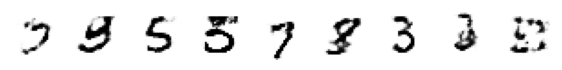

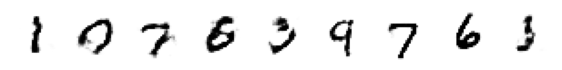

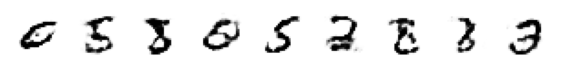

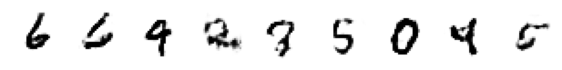

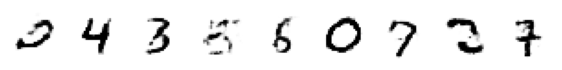

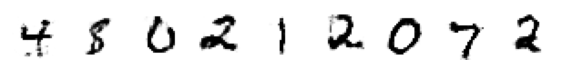

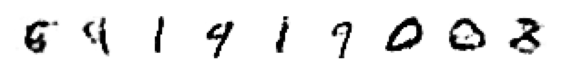

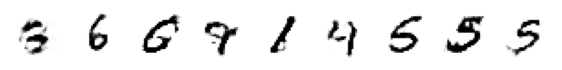

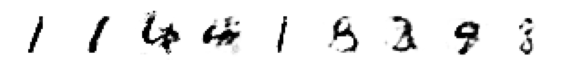

Epoch:140, Step:0, D-Loss:0.680, D-Acc:65.000, G-Loss:0.786
Epoch:140, Step:50, D-Loss:0.716, D-Acc:59.000, G-Loss:0.815
Epoch:140, Step:100, D-Loss:0.696, D-Acc:59.000, G-Loss:0.795
Epoch:140, Step:150, D-Loss:0.693, D-Acc:57.000, G-Loss:0.803
Epoch:140, Step:200, D-Loss:0.694, D-Acc:61.000, G-Loss:0.853
Epoch:140, Step:250, D-Loss:0.708, D-Acc:66.000, G-Loss:0.812
Epoch:140, Step:300, D-Loss:0.680, D-Acc:66.000, G-Loss:0.763
Epoch:140, Step:350, D-Loss:0.714, D-Acc:56.000, G-Loss:0.776
Epoch:141, Step:0, D-Loss:0.702, D-Acc:66.000, G-Loss:0.766
Epoch:141, Step:50, D-Loss:0.678, D-Acc:68.000, G-Loss:0.806
Epoch:141, Step:100, D-Loss:0.726, D-Acc:51.000, G-Loss:0.844
Epoch:141, Step:150, D-Loss:0.695, D-Acc:66.000, G-Loss:0.821
Epoch:141, Step:200, D-Loss:0.716, D-Acc:58.000, G-Loss:0.800
Epoch:141, Step:250, D-Loss:0.690, D-Acc:71.000, G-Loss:0.824
Epoch:141, Step:300, D-Loss:0.710, D-Acc:61.000, G-Loss:0.777
Epoch:141, Step:350, D-Loss:0.695, D-Acc:63.000, G-Loss:0.785
Epoch:142, Ste

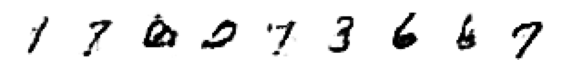

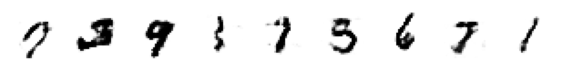

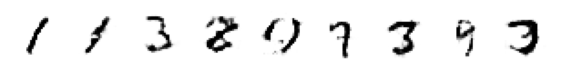

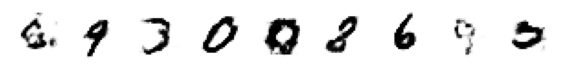

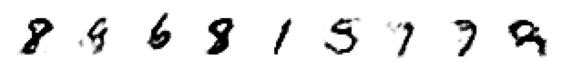

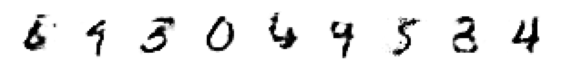

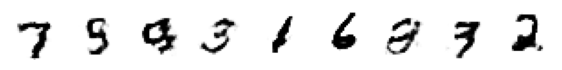

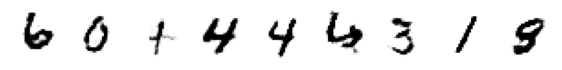

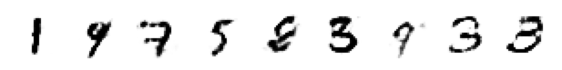

Epoch:150, Step:0, D-Loss:0.670, D-Acc:70.000, G-Loss:0.790
Epoch:150, Step:50, D-Loss:0.711, D-Acc:49.000, G-Loss:0.767
Epoch:150, Step:100, D-Loss:0.690, D-Acc:61.000, G-Loss:0.789
Epoch:150, Step:150, D-Loss:0.688, D-Acc:63.000, G-Loss:0.815
Epoch:150, Step:200, D-Loss:0.693, D-Acc:63.000, G-Loss:0.816
Epoch:150, Step:250, D-Loss:0.688, D-Acc:69.000, G-Loss:0.749
Epoch:150, Step:300, D-Loss:0.677, D-Acc:60.000, G-Loss:0.809
Epoch:150, Step:350, D-Loss:0.699, D-Acc:65.000, G-Loss:0.814
Epoch:151, Step:0, D-Loss:0.702, D-Acc:64.000, G-Loss:0.819
Epoch:151, Step:50, D-Loss:0.696, D-Acc:67.000, G-Loss:0.815
Epoch:151, Step:100, D-Loss:0.689, D-Acc:63.000, G-Loss:0.773
Epoch:151, Step:150, D-Loss:0.709, D-Acc:66.000, G-Loss:0.788
Epoch:151, Step:200, D-Loss:0.728, D-Acc:48.000, G-Loss:0.810
Epoch:151, Step:250, D-Loss:0.665, D-Acc:76.000, G-Loss:0.821
Epoch:151, Step:300, D-Loss:0.692, D-Acc:65.000, G-Loss:0.824
Epoch:151, Step:350, D-Loss:0.704, D-Acc:57.000, G-Loss:0.818
Epoch:152, Ste

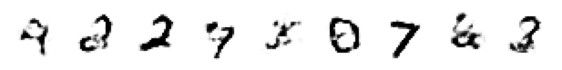

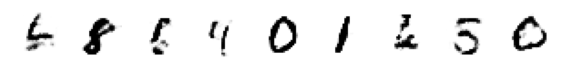

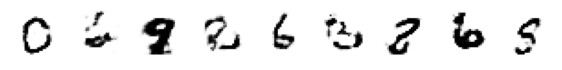

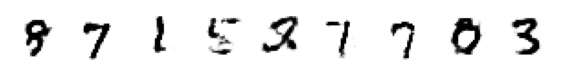

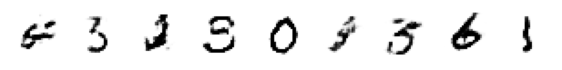

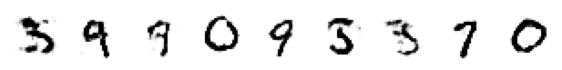

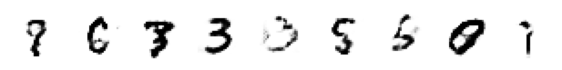

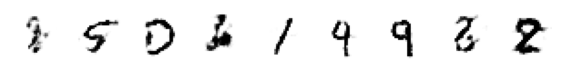

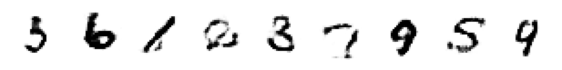

Epoch:160, Step:0, D-Loss:0.707, D-Acc:60.000, G-Loss:0.808
Epoch:160, Step:50, D-Loss:0.709, D-Acc:59.000, G-Loss:0.785
Epoch:160, Step:100, D-Loss:0.684, D-Acc:68.000, G-Loss:0.797
Epoch:160, Step:150, D-Loss:0.719, D-Acc:62.000, G-Loss:0.814
Epoch:160, Step:200, D-Loss:0.683, D-Acc:69.000, G-Loss:0.801
Epoch:160, Step:250, D-Loss:0.721, D-Acc:52.000, G-Loss:0.783
Epoch:160, Step:300, D-Loss:0.700, D-Acc:66.000, G-Loss:0.810
Epoch:160, Step:350, D-Loss:0.727, D-Acc:57.000, G-Loss:0.808
Epoch:161, Step:0, D-Loss:0.694, D-Acc:65.000, G-Loss:0.794
Epoch:161, Step:50, D-Loss:0.685, D-Acc:63.000, G-Loss:0.791
Epoch:161, Step:100, D-Loss:0.705, D-Acc:66.000, G-Loss:0.809
Epoch:161, Step:150, D-Loss:0.712, D-Acc:59.000, G-Loss:0.800
Epoch:161, Step:200, D-Loss:0.699, D-Acc:67.000, G-Loss:0.768
Epoch:161, Step:250, D-Loss:0.679, D-Acc:67.000, G-Loss:0.790
Epoch:161, Step:300, D-Loss:0.709, D-Acc:59.000, G-Loss:0.815
Epoch:161, Step:350, D-Loss:0.675, D-Acc:66.000, G-Loss:0.804
Epoch:162, Ste

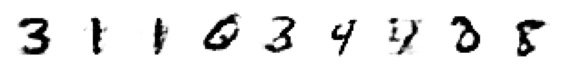

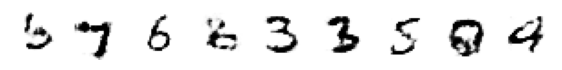

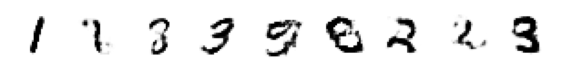

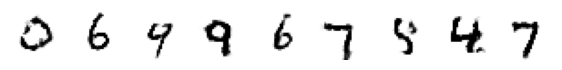

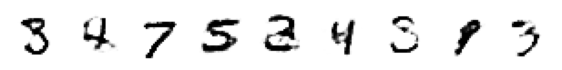

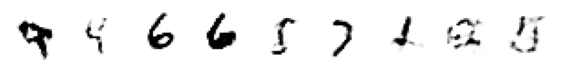

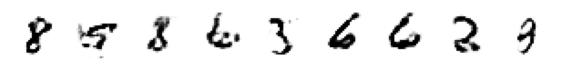

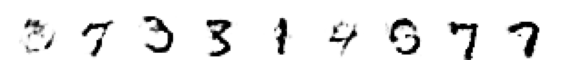

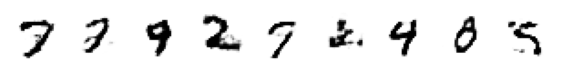

Epoch:170, Step:0, D-Loss:0.708, D-Acc:61.000, G-Loss:0.815
Epoch:170, Step:50, D-Loss:0.685, D-Acc:68.000, G-Loss:0.852
Epoch:170, Step:100, D-Loss:0.706, D-Acc:56.000, G-Loss:0.802
Epoch:170, Step:150, D-Loss:0.709, D-Acc:59.000, G-Loss:0.785
Epoch:170, Step:200, D-Loss:0.709, D-Acc:61.000, G-Loss:0.787
Epoch:170, Step:250, D-Loss:0.688, D-Acc:67.000, G-Loss:0.757
Epoch:170, Step:300, D-Loss:0.700, D-Acc:60.000, G-Loss:0.794
Epoch:170, Step:350, D-Loss:0.673, D-Acc:65.000, G-Loss:0.793
Epoch:171, Step:0, D-Loss:0.690, D-Acc:65.000, G-Loss:0.821
Epoch:171, Step:50, D-Loss:0.698, D-Acc:63.000, G-Loss:0.806
Epoch:171, Step:100, D-Loss:0.716, D-Acc:54.000, G-Loss:0.808
Epoch:171, Step:150, D-Loss:0.715, D-Acc:62.000, G-Loss:0.816
Epoch:171, Step:200, D-Loss:0.698, D-Acc:64.000, G-Loss:0.790
Epoch:171, Step:250, D-Loss:0.711, D-Acc:55.000, G-Loss:0.795
Epoch:171, Step:300, D-Loss:0.724, D-Acc:56.000, G-Loss:0.801
Epoch:171, Step:350, D-Loss:0.700, D-Acc:60.000, G-Loss:0.766
Epoch:172, Ste

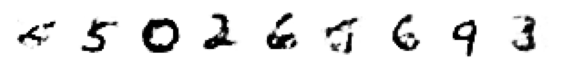

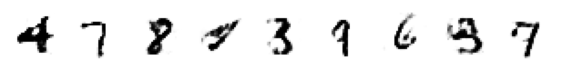

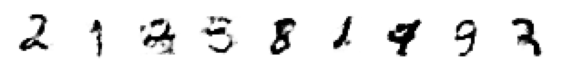

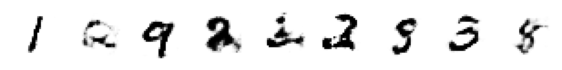

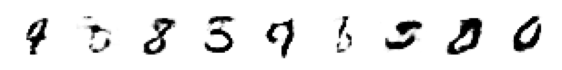

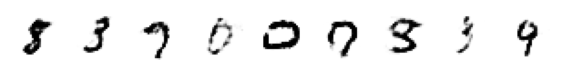

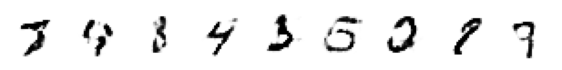

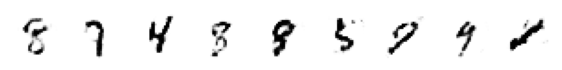

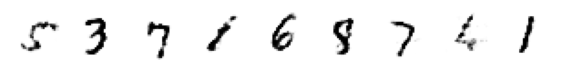

Epoch:180, Step:0, D-Loss:0.691, D-Acc:67.000, G-Loss:0.790
Epoch:180, Step:50, D-Loss:0.682, D-Acc:68.000, G-Loss:0.794
Epoch:180, Step:100, D-Loss:0.697, D-Acc:61.000, G-Loss:0.780
Epoch:180, Step:150, D-Loss:0.686, D-Acc:62.000, G-Loss:0.792
Epoch:180, Step:200, D-Loss:0.696, D-Acc:65.000, G-Loss:0.810
Epoch:180, Step:250, D-Loss:0.711, D-Acc:62.000, G-Loss:0.786
Epoch:180, Step:300, D-Loss:0.693, D-Acc:63.000, G-Loss:0.783
Epoch:180, Step:350, D-Loss:0.707, D-Acc:63.000, G-Loss:0.803
Epoch:181, Step:0, D-Loss:0.702, D-Acc:57.000, G-Loss:0.818
Epoch:181, Step:50, D-Loss:0.701, D-Acc:60.000, G-Loss:0.792
Epoch:181, Step:100, D-Loss:0.704, D-Acc:58.000, G-Loss:0.804
Epoch:181, Step:150, D-Loss:0.715, D-Acc:60.000, G-Loss:0.802
Epoch:181, Step:200, D-Loss:0.682, D-Acc:64.000, G-Loss:0.815
Epoch:181, Step:250, D-Loss:0.701, D-Acc:59.000, G-Loss:0.802
Epoch:181, Step:300, D-Loss:0.716, D-Acc:58.000, G-Loss:0.778
Epoch:181, Step:350, D-Loss:0.684, D-Acc:67.000, G-Loss:0.778
Epoch:182, Ste

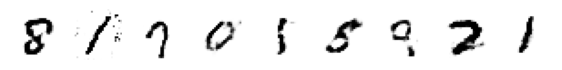

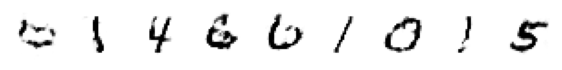

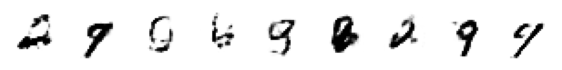

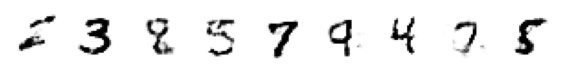

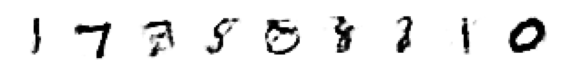

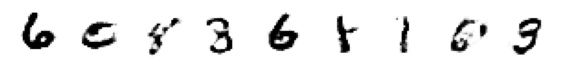

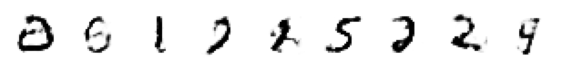

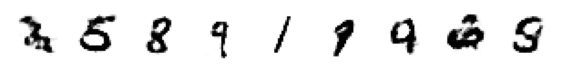

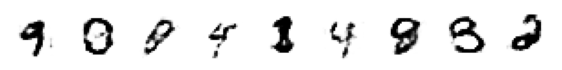

Epoch:190, Step:0, D-Loss:0.686, D-Acc:67.000, G-Loss:0.813
Epoch:190, Step:50, D-Loss:0.705, D-Acc:60.000, G-Loss:0.777
Epoch:190, Step:100, D-Loss:0.666, D-Acc:66.000, G-Loss:0.767
Epoch:190, Step:150, D-Loss:0.691, D-Acc:61.000, G-Loss:0.766
Epoch:190, Step:200, D-Loss:0.706, D-Acc:61.000, G-Loss:0.807
Epoch:190, Step:250, D-Loss:0.712, D-Acc:54.000, G-Loss:0.772
Epoch:190, Step:300, D-Loss:0.714, D-Acc:57.000, G-Loss:0.751
Epoch:190, Step:350, D-Loss:0.696, D-Acc:62.000, G-Loss:0.754
Epoch:191, Step:0, D-Loss:0.686, D-Acc:61.000, G-Loss:0.798
Epoch:191, Step:50, D-Loss:0.702, D-Acc:62.000, G-Loss:0.823
Epoch:191, Step:100, D-Loss:0.736, D-Acc:53.000, G-Loss:0.795
Epoch:191, Step:150, D-Loss:0.703, D-Acc:56.000, G-Loss:0.783
Epoch:191, Step:200, D-Loss:0.707, D-Acc:59.000, G-Loss:0.786
Epoch:191, Step:250, D-Loss:0.703, D-Acc:64.000, G-Loss:0.808
Epoch:191, Step:300, D-Loss:0.659, D-Acc:77.000, G-Loss:0.801
Epoch:191, Step:350, D-Loss:0.689, D-Acc:65.000, G-Loss:0.802
Epoch:192, Ste

In [ ]:
epochs = 200
batch_size = 100
steps = 400
noise_size = 50

losses_d = []
losses_g = []

for i in range(0, epochs):
    if (i%10 == 0):
        show_generator_results(generator_network)
    for j in range(steps):
        fake_samples = get_fake_samples(generator_network, batch_size//2, noise_size)
        real_samples = get_real_samples(batch_size=batch_size//2)

        fake_y = np.zeros((batch_size//2, 1))
        real_y = np.ones((batch_size//2, 1))

        input_batch = np.vstack((fake_samples, real_samples))
        output_labels = np.vstack((fake_y, real_y))

        # Updating Discriminator weights
        discriminator_network.trainable=True
        loss_d = discriminator_network.train_on_batch(input_batch, output_labels)

        gan_input = get_random_noise(batch_size, noise_size)

        # Make the Discriminator belive that these are real samples and calculate loss to train the generator
        gan_output = np.ones((batch_size))

        # Updating Generator weights
        discriminator_network.trainable=False
        loss_g = gan_model.train_on_batch(gan_input, gan_output)

        losses_d.append(loss_d[0])
        losses_g.append(loss_g)

        if j%50 == 0:
            print ("Epoch:%.0f, Step:%.0f, D-Loss:%.3f, D-Acc:%.3f, G-Loss:%.3f"%(i,j,loss_d[0],loss_d[1]*100,loss_g))

### Train lagi

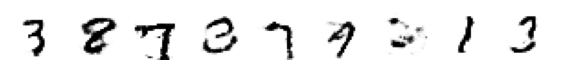

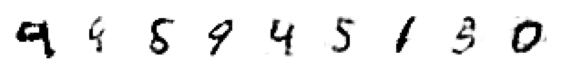

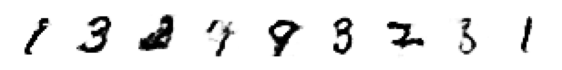

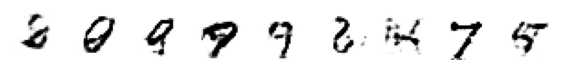

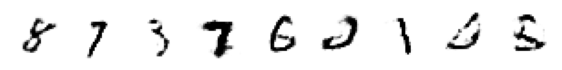

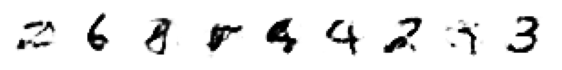

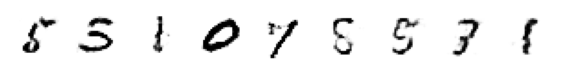

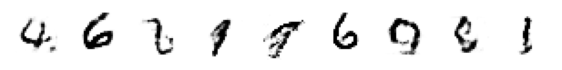

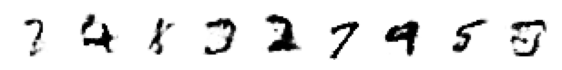

Epoch:0, Step:0, D-Loss:0.700, D-Acc:59.000, G-Loss:0.784
Epoch:0, Step:50, D-Loss:0.714, D-Acc:55.000, G-Loss:0.772
Epoch:0, Step:100, D-Loss:0.695, D-Acc:62.000, G-Loss:0.772
Epoch:0, Step:150, D-Loss:0.688, D-Acc:58.000, G-Loss:0.777
Epoch:0, Step:200, D-Loss:0.681, D-Acc:70.000, G-Loss:0.779
Epoch:0, Step:250, D-Loss:0.677, D-Acc:66.000, G-Loss:0.780
Epoch:0, Step:300, D-Loss:0.686, D-Acc:69.000, G-Loss:0.790
Epoch:0, Step:350, D-Loss:0.707, D-Acc:64.000, G-Loss:0.791
Epoch:1, Step:0, D-Loss:0.702, D-Acc:59.000, G-Loss:0.773
Epoch:1, Step:50, D-Loss:0.671, D-Acc:70.000, G-Loss:0.827
Epoch:1, Step:100, D-Loss:0.690, D-Acc:61.000, G-Loss:0.814
Epoch:1, Step:150, D-Loss:0.727, D-Acc:53.000, G-Loss:0.800
Epoch:1, Step:200, D-Loss:0.687, D-Acc:68.000, G-Loss:0.788
Epoch:1, Step:250, D-Loss:0.713, D-Acc:58.000, G-Loss:0.789
Epoch:1, Step:300, D-Loss:0.719, D-Acc:57.000, G-Loss:0.779
Epoch:1, Step:350, D-Loss:0.672, D-Acc:70.000, G-Loss:0.801
Epoch:2, Step:0, D-Loss:0.700, D-Acc:59.000, G

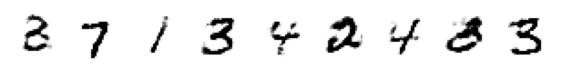

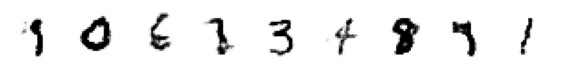

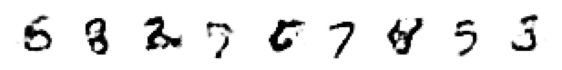

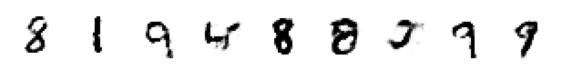

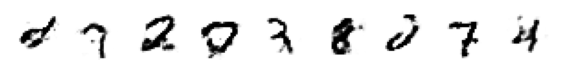

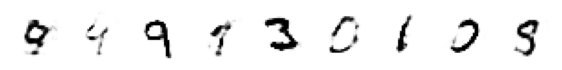

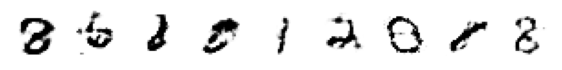

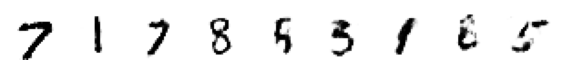

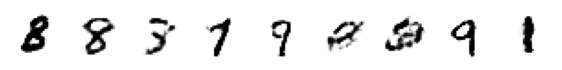

Epoch:10, Step:0, D-Loss:0.689, D-Acc:66.000, G-Loss:0.808
Epoch:10, Step:50, D-Loss:0.689, D-Acc:65.000, G-Loss:0.759
Epoch:10, Step:100, D-Loss:0.679, D-Acc:69.000, G-Loss:0.753
Epoch:10, Step:150, D-Loss:0.720, D-Acc:55.000, G-Loss:0.792
Epoch:10, Step:200, D-Loss:0.676, D-Acc:66.000, G-Loss:0.771
Epoch:10, Step:250, D-Loss:0.699, D-Acc:59.000, G-Loss:0.768
Epoch:10, Step:300, D-Loss:0.699, D-Acc:61.000, G-Loss:0.785
Epoch:10, Step:350, D-Loss:0.683, D-Acc:61.000, G-Loss:0.791
Epoch:11, Step:0, D-Loss:0.715, D-Acc:60.000, G-Loss:0.780
Epoch:11, Step:50, D-Loss:0.699, D-Acc:62.000, G-Loss:0.801
Epoch:11, Step:100, D-Loss:0.686, D-Acc:63.000, G-Loss:0.780
Epoch:11, Step:150, D-Loss:0.686, D-Acc:66.000, G-Loss:0.777
Epoch:11, Step:200, D-Loss:0.671, D-Acc:70.000, G-Loss:0.795
Epoch:11, Step:250, D-Loss:0.720, D-Acc:56.000, G-Loss:0.780
Epoch:11, Step:300, D-Loss:0.699, D-Acc:57.000, G-Loss:0.771
Epoch:11, Step:350, D-Loss:0.707, D-Acc:58.000, G-Loss:0.784
Epoch:12, Step:0, D-Loss:0.696

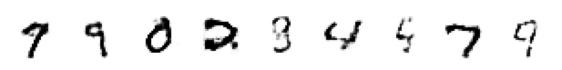

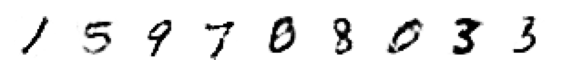

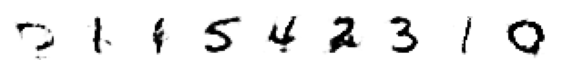

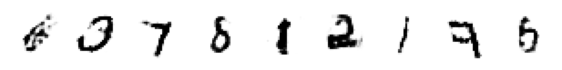

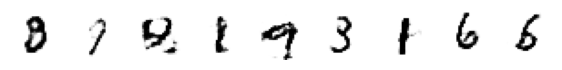

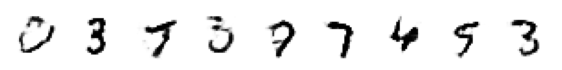

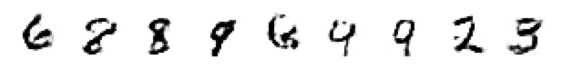

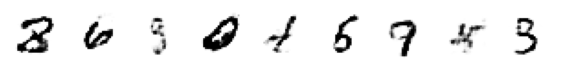

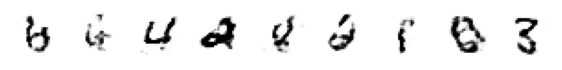

Epoch:20, Step:0, D-Loss:0.709, D-Acc:55.000, G-Loss:0.754
Epoch:20, Step:50, D-Loss:0.697, D-Acc:63.000, G-Loss:0.777
Epoch:20, Step:100, D-Loss:0.706, D-Acc:56.000, G-Loss:0.816
Epoch:20, Step:150, D-Loss:0.715, D-Acc:59.000, G-Loss:0.804
Epoch:20, Step:200, D-Loss:0.697, D-Acc:63.000, G-Loss:0.788
Epoch:20, Step:250, D-Loss:0.720, D-Acc:51.000, G-Loss:0.772
Epoch:20, Step:300, D-Loss:0.700, D-Acc:58.000, G-Loss:0.774
Epoch:20, Step:350, D-Loss:0.693, D-Acc:62.000, G-Loss:0.775
Epoch:21, Step:0, D-Loss:0.702, D-Acc:61.000, G-Loss:0.792
Epoch:21, Step:50, D-Loss:0.707, D-Acc:56.000, G-Loss:0.809
Epoch:21, Step:100, D-Loss:0.703, D-Acc:58.000, G-Loss:0.815
Epoch:21, Step:150, D-Loss:0.677, D-Acc:65.000, G-Loss:0.769
Epoch:21, Step:200, D-Loss:0.701, D-Acc:59.000, G-Loss:0.764
Epoch:21, Step:250, D-Loss:0.681, D-Acc:65.000, G-Loss:0.760
Epoch:21, Step:300, D-Loss:0.701, D-Acc:58.000, G-Loss:0.787
Epoch:21, Step:350, D-Loss:0.698, D-Acc:60.000, G-Loss:0.822
Epoch:22, Step:0, D-Loss:0.693

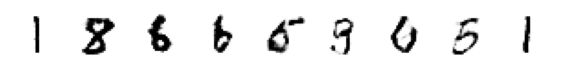

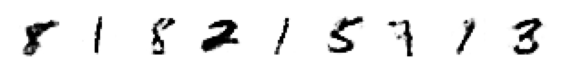

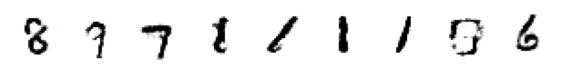

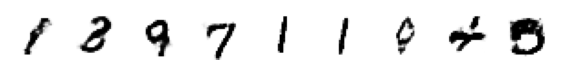

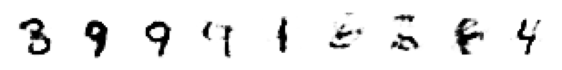

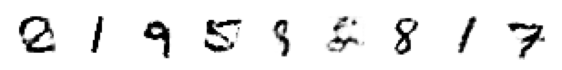

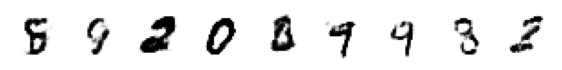

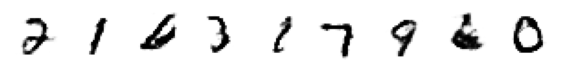

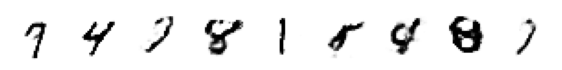

Epoch:30, Step:0, D-Loss:0.697, D-Acc:52.000, G-Loss:0.776
Epoch:30, Step:50, D-Loss:0.689, D-Acc:65.000, G-Loss:0.756
Epoch:30, Step:100, D-Loss:0.697, D-Acc:59.000, G-Loss:0.749
Epoch:30, Step:150, D-Loss:0.703, D-Acc:60.000, G-Loss:0.757
Epoch:30, Step:200, D-Loss:0.693, D-Acc:65.000, G-Loss:0.789
Epoch:30, Step:250, D-Loss:0.705, D-Acc:61.000, G-Loss:0.772
Epoch:30, Step:300, D-Loss:0.713, D-Acc:54.000, G-Loss:0.781
Epoch:30, Step:350, D-Loss:0.698, D-Acc:61.000, G-Loss:0.774
Epoch:31, Step:0, D-Loss:0.691, D-Acc:66.000, G-Loss:0.776
Epoch:31, Step:50, D-Loss:0.685, D-Acc:62.000, G-Loss:0.756
Epoch:31, Step:100, D-Loss:0.694, D-Acc:63.000, G-Loss:0.740
Epoch:31, Step:150, D-Loss:0.726, D-Acc:53.000, G-Loss:0.798
Epoch:31, Step:200, D-Loss:0.713, D-Acc:55.000, G-Loss:0.772
Epoch:31, Step:250, D-Loss:0.708, D-Acc:60.000, G-Loss:0.779
Epoch:31, Step:300, D-Loss:0.700, D-Acc:61.000, G-Loss:0.771
Epoch:31, Step:350, D-Loss:0.690, D-Acc:64.000, G-Loss:0.798
Epoch:32, Step:0, D-Loss:0.698

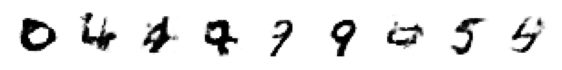

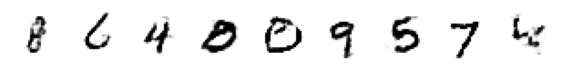

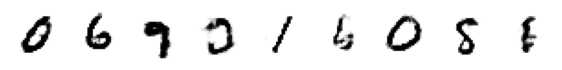

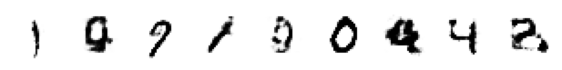

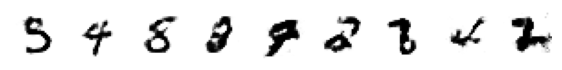

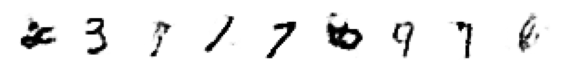

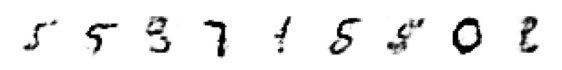

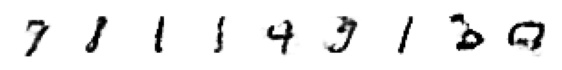

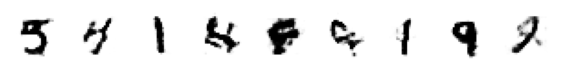

Epoch:40, Step:0, D-Loss:0.708, D-Acc:58.000, G-Loss:0.769
Epoch:40, Step:50, D-Loss:0.712, D-Acc:58.000, G-Loss:0.774
Epoch:40, Step:100, D-Loss:0.689, D-Acc:64.000, G-Loss:0.751
Epoch:40, Step:150, D-Loss:0.732, D-Acc:52.000, G-Loss:0.733
Epoch:40, Step:200, D-Loss:0.700, D-Acc:60.000, G-Loss:0.770
Epoch:40, Step:250, D-Loss:0.700, D-Acc:63.000, G-Loss:0.740
Epoch:40, Step:300, D-Loss:0.698, D-Acc:61.000, G-Loss:0.825
Epoch:40, Step:350, D-Loss:0.707, D-Acc:60.000, G-Loss:0.731
Epoch:41, Step:0, D-Loss:0.716, D-Acc:54.000, G-Loss:0.763
Epoch:41, Step:50, D-Loss:0.688, D-Acc:65.000, G-Loss:0.764
Epoch:41, Step:100, D-Loss:0.692, D-Acc:67.000, G-Loss:0.782
Epoch:41, Step:150, D-Loss:0.705, D-Acc:55.000, G-Loss:0.767
Epoch:41, Step:200, D-Loss:0.694, D-Acc:59.000, G-Loss:0.760
Epoch:41, Step:250, D-Loss:0.697, D-Acc:68.000, G-Loss:0.773
Epoch:41, Step:300, D-Loss:0.691, D-Acc:61.000, G-Loss:0.764
Epoch:41, Step:350, D-Loss:0.701, D-Acc:62.000, G-Loss:0.782
Epoch:42, Step:0, D-Loss:0.701

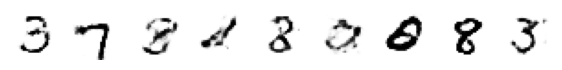

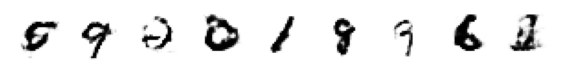

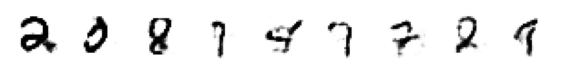

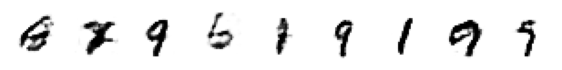

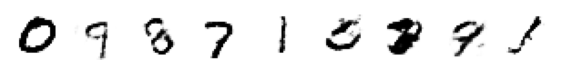

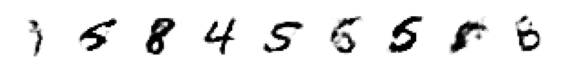

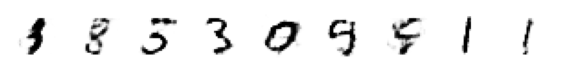

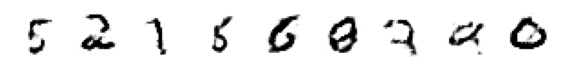

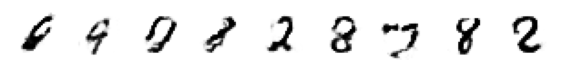

Epoch:50, Step:0, D-Loss:0.701, D-Acc:59.000, G-Loss:0.769
Epoch:50, Step:50, D-Loss:0.675, D-Acc:67.000, G-Loss:0.749
Epoch:50, Step:100, D-Loss:0.689, D-Acc:60.000, G-Loss:0.791
Epoch:50, Step:150, D-Loss:0.694, D-Acc:65.000, G-Loss:0.742
Epoch:50, Step:200, D-Loss:0.686, D-Acc:66.000, G-Loss:0.780
Epoch:50, Step:250, D-Loss:0.698, D-Acc:59.000, G-Loss:0.769
Epoch:50, Step:300, D-Loss:0.701, D-Acc:60.000, G-Loss:0.777
Epoch:50, Step:350, D-Loss:0.707, D-Acc:58.000, G-Loss:0.739
Epoch:51, Step:0, D-Loss:0.683, D-Acc:66.000, G-Loss:0.772
Epoch:51, Step:50, D-Loss:0.708, D-Acc:53.000, G-Loss:0.782
Epoch:51, Step:100, D-Loss:0.713, D-Acc:54.000, G-Loss:0.779
Epoch:51, Step:150, D-Loss:0.688, D-Acc:65.000, G-Loss:0.753
Epoch:51, Step:200, D-Loss:0.719, D-Acc:52.000, G-Loss:0.752
Epoch:51, Step:250, D-Loss:0.698, D-Acc:64.000, G-Loss:0.757
Epoch:51, Step:300, D-Loss:0.705, D-Acc:57.000, G-Loss:0.750
Epoch:51, Step:350, D-Loss:0.718, D-Acc:60.000, G-Loss:0.758
Epoch:52, Step:0, D-Loss:0.720

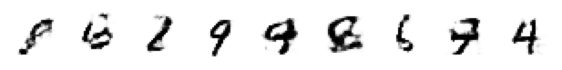

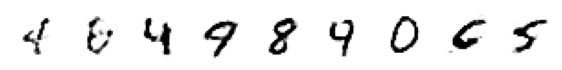

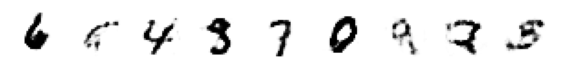

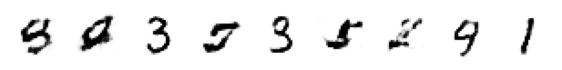

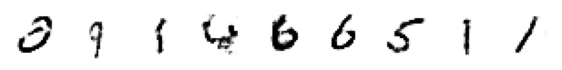

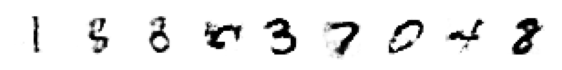

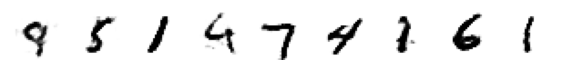

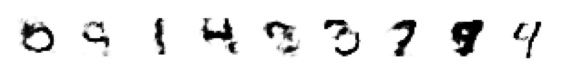

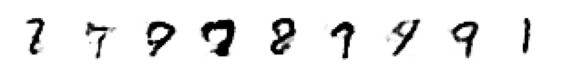

Epoch:60, Step:0, D-Loss:0.711, D-Acc:57.000, G-Loss:0.759
Epoch:60, Step:50, D-Loss:0.698, D-Acc:63.000, G-Loss:0.791
Epoch:60, Step:100, D-Loss:0.712, D-Acc:53.000, G-Loss:0.775
Epoch:60, Step:150, D-Loss:0.715, D-Acc:52.000, G-Loss:0.751
Epoch:60, Step:200, D-Loss:0.725, D-Acc:45.000, G-Loss:0.757
Epoch:60, Step:250, D-Loss:0.706, D-Acc:58.000, G-Loss:0.803
Epoch:60, Step:300, D-Loss:0.704, D-Acc:58.000, G-Loss:0.745
Epoch:60, Step:350, D-Loss:0.696, D-Acc:63.000, G-Loss:0.749
Epoch:61, Step:0, D-Loss:0.710, D-Acc:59.000, G-Loss:0.756
Epoch:61, Step:50, D-Loss:0.717, D-Acc:54.000, G-Loss:0.761
Epoch:61, Step:100, D-Loss:0.689, D-Acc:61.000, G-Loss:0.781
Epoch:61, Step:150, D-Loss:0.707, D-Acc:59.000, G-Loss:0.743
Epoch:61, Step:200, D-Loss:0.696, D-Acc:61.000, G-Loss:0.777
Epoch:61, Step:250, D-Loss:0.709, D-Acc:56.000, G-Loss:0.744
Epoch:61, Step:300, D-Loss:0.688, D-Acc:61.000, G-Loss:0.752
Epoch:61, Step:350, D-Loss:0.693, D-Acc:65.000, G-Loss:0.768
Epoch:62, Step:0, D-Loss:0.721

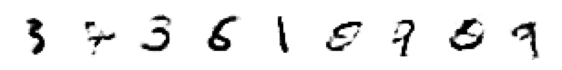

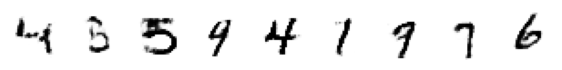

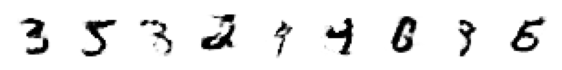

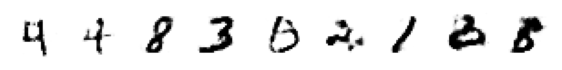

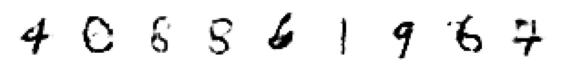

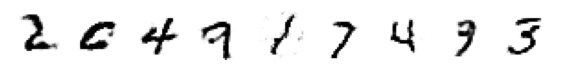

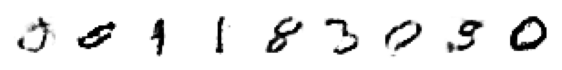

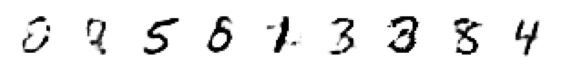

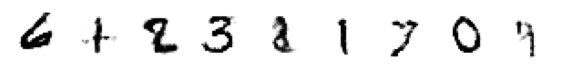

Epoch:70, Step:0, D-Loss:0.698, D-Acc:56.000, G-Loss:0.772
Epoch:70, Step:50, D-Loss:0.690, D-Acc:68.000, G-Loss:0.748
Epoch:70, Step:100, D-Loss:0.706, D-Acc:54.000, G-Loss:0.764
Epoch:70, Step:150, D-Loss:0.703, D-Acc:59.000, G-Loss:0.772
Epoch:70, Step:200, D-Loss:0.720, D-Acc:54.000, G-Loss:0.759
Epoch:70, Step:250, D-Loss:0.699, D-Acc:55.000, G-Loss:0.756
Epoch:70, Step:300, D-Loss:0.681, D-Acc:67.000, G-Loss:0.748
Epoch:70, Step:350, D-Loss:0.695, D-Acc:61.000, G-Loss:0.762
Epoch:71, Step:0, D-Loss:0.699, D-Acc:66.000, G-Loss:0.748
Epoch:71, Step:50, D-Loss:0.684, D-Acc:66.000, G-Loss:0.757
Epoch:71, Step:100, D-Loss:0.673, D-Acc:69.000, G-Loss:0.770
Epoch:71, Step:150, D-Loss:0.698, D-Acc:59.000, G-Loss:0.757
Epoch:71, Step:200, D-Loss:0.694, D-Acc:60.000, G-Loss:0.769
Epoch:71, Step:250, D-Loss:0.705, D-Acc:58.000, G-Loss:0.732
Epoch:71, Step:300, D-Loss:0.703, D-Acc:57.000, G-Loss:0.746
Epoch:71, Step:350, D-Loss:0.677, D-Acc:70.000, G-Loss:0.786
Epoch:72, Step:0, D-Loss:0.691

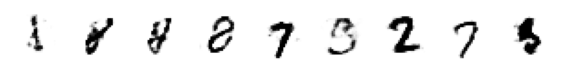

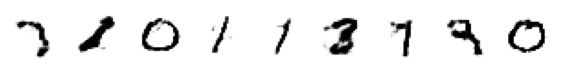

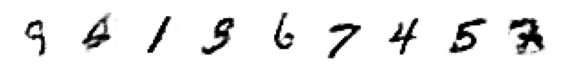

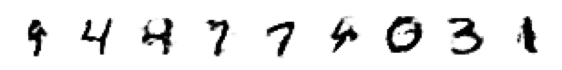

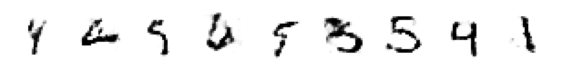

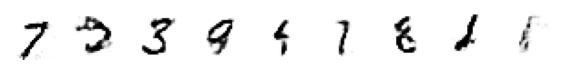

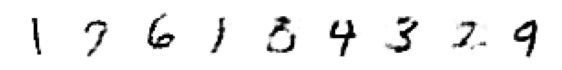

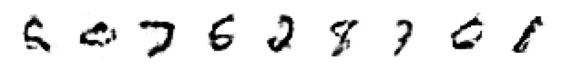

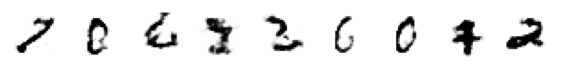

Epoch:80, Step:0, D-Loss:0.705, D-Acc:62.000, G-Loss:0.775
Epoch:80, Step:50, D-Loss:0.691, D-Acc:65.000, G-Loss:0.755
Epoch:80, Step:100, D-Loss:0.677, D-Acc:68.000, G-Loss:0.777
Epoch:80, Step:150, D-Loss:0.693, D-Acc:62.000, G-Loss:0.741
Epoch:80, Step:200, D-Loss:0.708, D-Acc:60.000, G-Loss:0.748
Epoch:80, Step:250, D-Loss:0.708, D-Acc:56.000, G-Loss:0.750
Epoch:80, Step:300, D-Loss:0.698, D-Acc:56.000, G-Loss:0.757
Epoch:80, Step:350, D-Loss:0.712, D-Acc:51.000, G-Loss:0.741
Epoch:81, Step:0, D-Loss:0.685, D-Acc:61.000, G-Loss:0.744
Epoch:81, Step:50, D-Loss:0.717, D-Acc:48.000, G-Loss:0.789
Epoch:81, Step:100, D-Loss:0.686, D-Acc:57.000, G-Loss:0.750
Epoch:81, Step:150, D-Loss:0.710, D-Acc:53.000, G-Loss:0.741
Epoch:81, Step:200, D-Loss:0.690, D-Acc:56.000, G-Loss:0.770
Epoch:81, Step:250, D-Loss:0.699, D-Acc:59.000, G-Loss:0.733
Epoch:81, Step:300, D-Loss:0.718, D-Acc:53.000, G-Loss:0.743
Epoch:81, Step:350, D-Loss:0.696, D-Acc:63.000, G-Loss:0.778
Epoch:82, Step:0, D-Loss:0.700

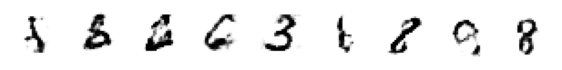

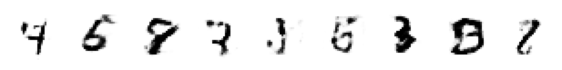

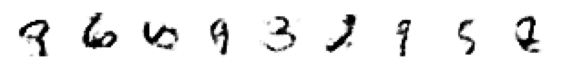

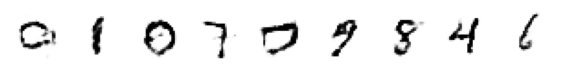

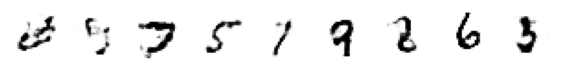

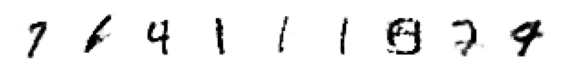

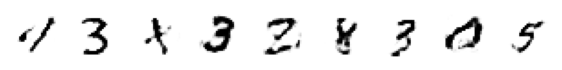

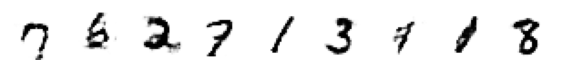

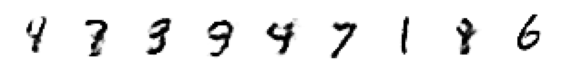

Epoch:90, Step:0, D-Loss:0.692, D-Acc:55.000, G-Loss:0.768
Epoch:90, Step:50, D-Loss:0.703, D-Acc:60.000, G-Loss:0.750
Epoch:90, Step:100, D-Loss:0.681, D-Acc:66.000, G-Loss:0.743
Epoch:90, Step:150, D-Loss:0.716, D-Acc:54.000, G-Loss:0.755
Epoch:90, Step:200, D-Loss:0.693, D-Acc:64.000, G-Loss:0.735
Epoch:90, Step:250, D-Loss:0.694, D-Acc:59.000, G-Loss:0.765
Epoch:90, Step:300, D-Loss:0.710, D-Acc:52.000, G-Loss:0.754
Epoch:90, Step:350, D-Loss:0.706, D-Acc:60.000, G-Loss:0.729
Epoch:91, Step:0, D-Loss:0.705, D-Acc:57.000, G-Loss:0.764
Epoch:91, Step:50, D-Loss:0.677, D-Acc:67.000, G-Loss:0.746
Epoch:91, Step:100, D-Loss:0.706, D-Acc:57.000, G-Loss:0.778
Epoch:91, Step:150, D-Loss:0.693, D-Acc:65.000, G-Loss:0.732
Epoch:91, Step:200, D-Loss:0.708, D-Acc:58.000, G-Loss:0.762
Epoch:91, Step:250, D-Loss:0.690, D-Acc:56.000, G-Loss:0.743
Epoch:91, Step:300, D-Loss:0.702, D-Acc:56.000, G-Loss:0.759
Epoch:91, Step:350, D-Loss:0.696, D-Acc:61.000, G-Loss:0.743
Epoch:92, Step:0, D-Loss:0.726

In [ ]:
epochs = 100
batch_size = 100
steps = 400
noise_size = 50

losses_d = []
losses_g = []

for i in range(0, epochs):
    if (i%10 == 0):
        show_generator_results(generator_network)
    for j in range(steps):
        fake_samples = get_fake_samples(generator_network, batch_size//2, noise_size)
        real_samples = get_real_samples(batch_size=batch_size//2)

        fake_y = np.zeros((batch_size//2, 1))
        real_y = np.ones((batch_size//2, 1))

        input_batch = np.vstack((fake_samples, real_samples))
        output_labels = np.vstack((fake_y, real_y))

        # Updating Discriminator weights
        discriminator_network.trainable=True
        loss_d = discriminator_network.train_on_batch(input_batch, output_labels)

        gan_input = get_random_noise(batch_size, noise_size)

        # Make the Discriminator belive that these are real samples and calculate loss to train the generator
        gan_output = np.ones((batch_size))

        # Updating Generator weights
        discriminator_network.trainable=False
        loss_g = gan_model.train_on_batch(gan_input, gan_output)

        losses_d.append(loss_d[0])
        losses_g.append(loss_g)

        if j%50 == 0:
            print ("Epoch:%.0f, Step:%.0f, D-Loss:%.3f, D-Acc:%.3f, G-Loss:%.3f"%(i,j,loss_d[0],loss_d[1]*100,loss_g))

In [ ]:
import numpy as np

def save_generator_output(generator_network, num_images=60000, filename="generated_images.npy"):
    noise_size = 50
    random_noise_batch = np.random.randn(num_images * noise_size)
    random_noise_batch = np.reshape(random_noise_batch, (num_images, noise_size))
    generated_images = generator_network.predict(random_noise_batch)
    np.save(filename, generated_images)
    print(f"Generated images saved to {filename}")

# Example usage (assuming generator_network is your trained model)
save_generator_output(generator_network)

1875/1875 [==============================] - 6s 3ms/step
Generated images saved to generated_images.npy


# Show Results

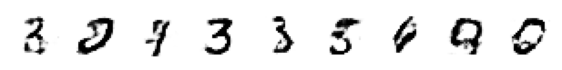

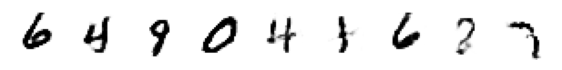

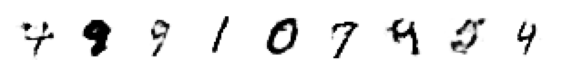

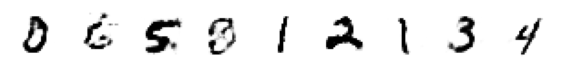

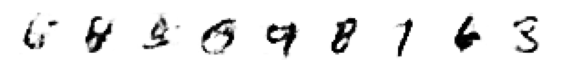

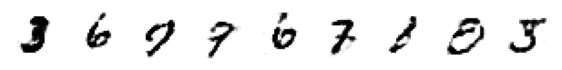

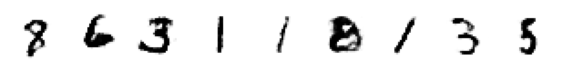

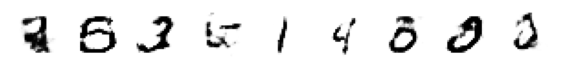

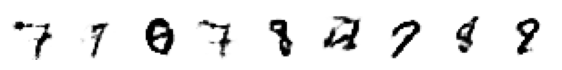

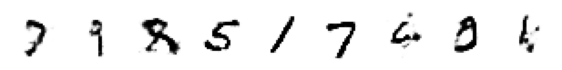

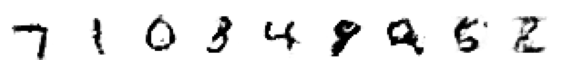

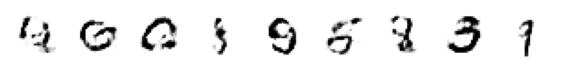

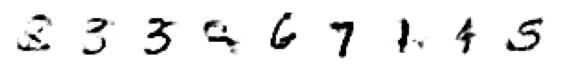

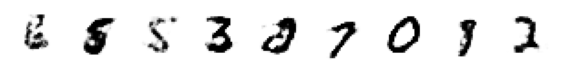

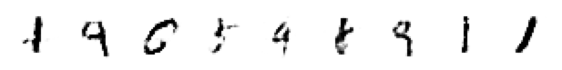

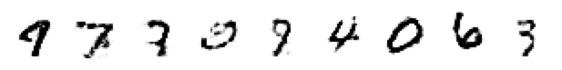

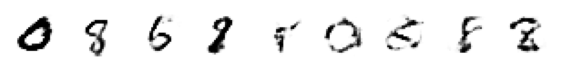

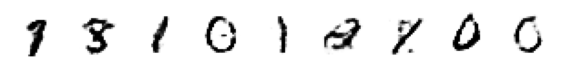

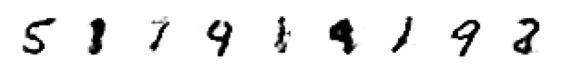

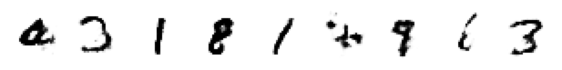

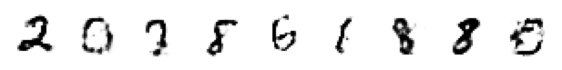

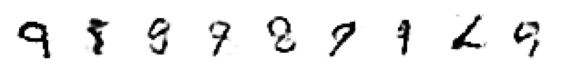

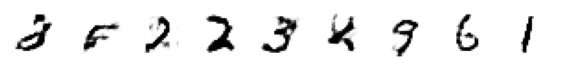

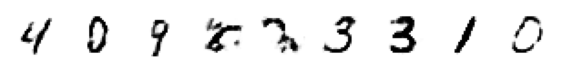

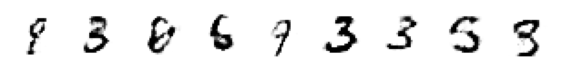

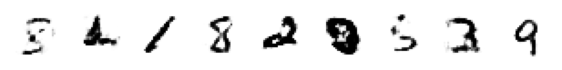

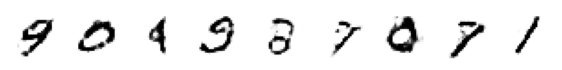

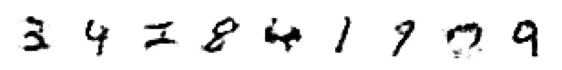

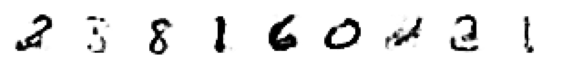

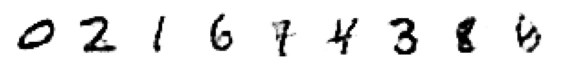

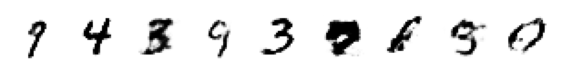

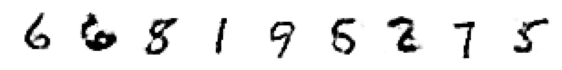

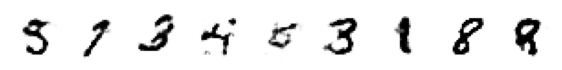

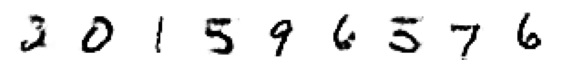

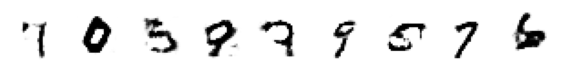

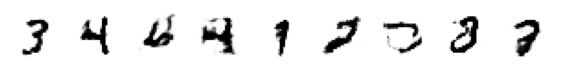

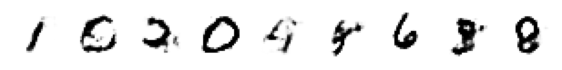

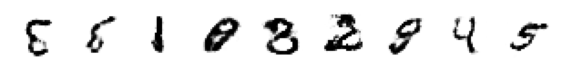

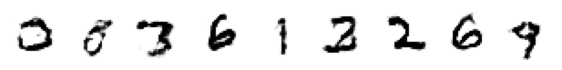

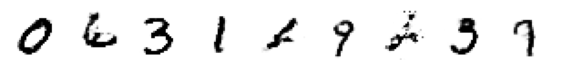

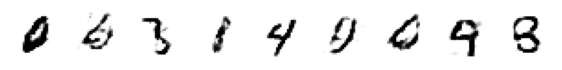

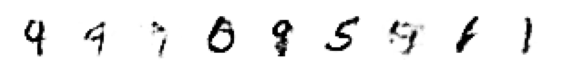

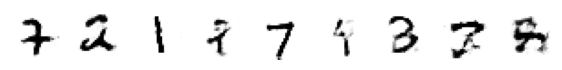

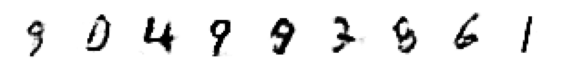

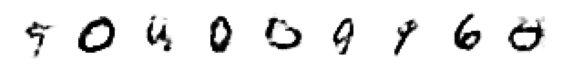

In [ ]:
#Generating Unlimited samples
noise_size=50
for i in range(5):
    show_generator_results(generator_network)

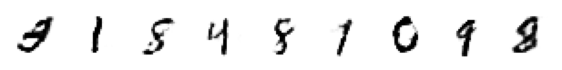

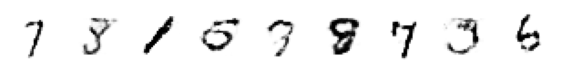

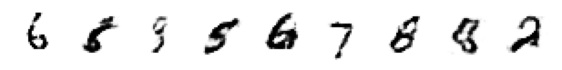

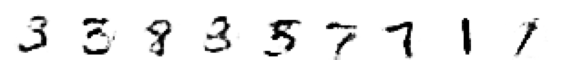

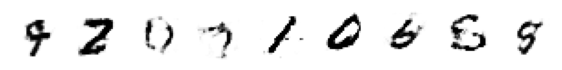

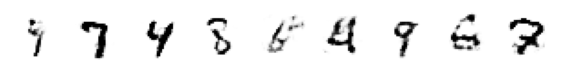

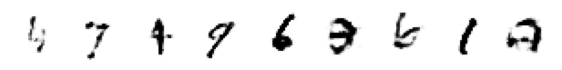

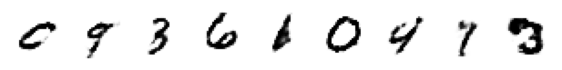

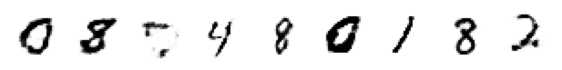

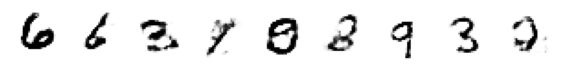

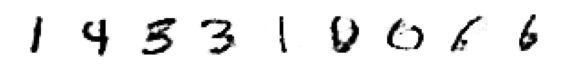

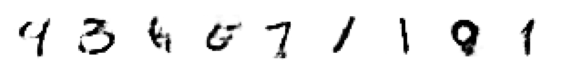

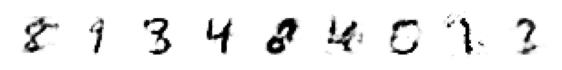

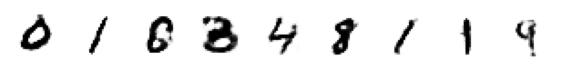

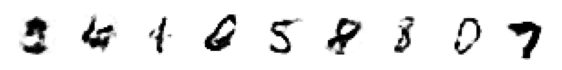

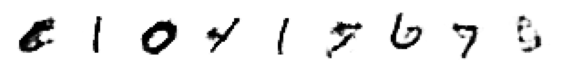

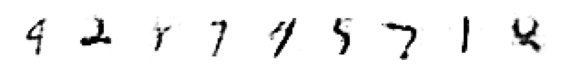

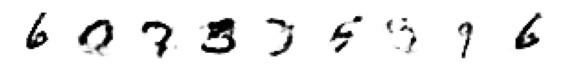

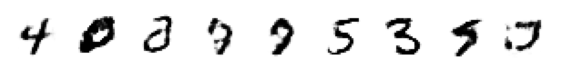

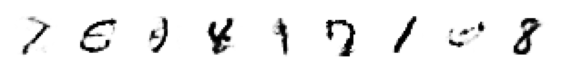

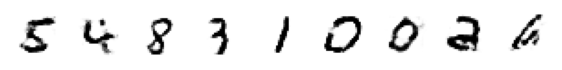

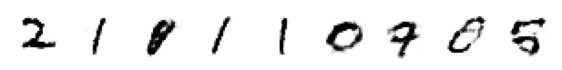

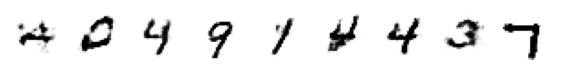

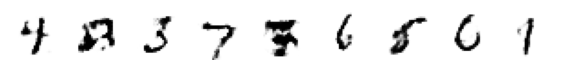

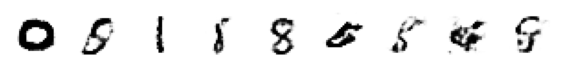

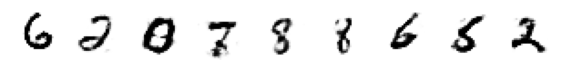

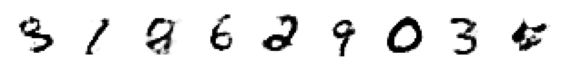

In [ ]:
#Generating Unlimited samples
noise_size=50
for i in range(5):
    show_generator_results(generator_network)

# Plot GAN loss

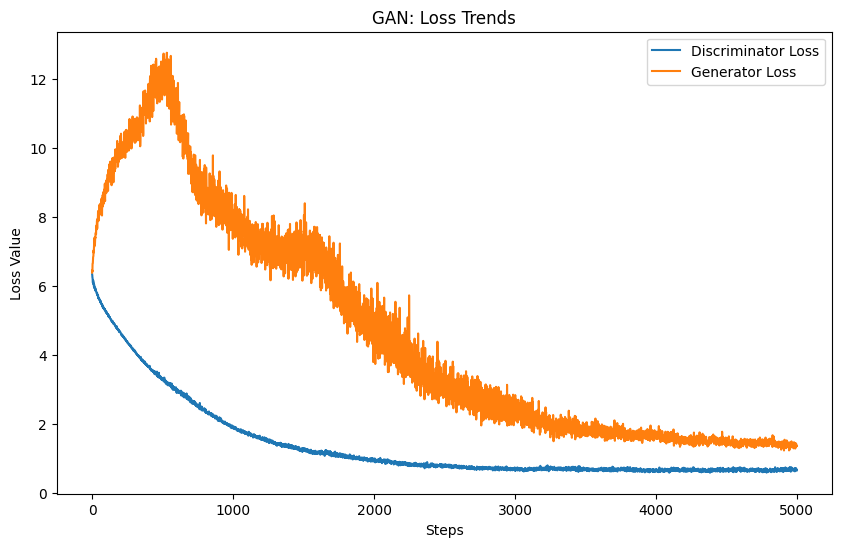

In [ ]:
steps = [i for i in range(len(losses_d))]
plt.figure(figsize=(10, 6))
plt.plot(losses_d[:5000])
plt.plot(losses_g[:5000])
plt.xlabel('Steps')
plt.ylabel('Loss Value')
plt.title("GAN: Loss Trends")
plt.legend(['Discriminator Loss', 'Generator Loss'])
plt.show()

# **Explanation of GAN Results**

**1. Discriminator Loss (Blue Line):**
  - Discriminator loss is at a low value after the first few epochs (after the 2nd epoch or around the 1000th step). This shows that the discriminator quickly becomes quite good at distinguishing between real and fake data.

**2. Generator Loss (Orange Line):**
  - Generator loss starts with the same number as the discriminator (5.9) then increases to the highest value (around 12) and shows a decrease after the 2nd epoch or around the 600th step, decreasing gradually as the epochs/step increase.
  - This decrease indicates that the learning generator produces more realistic data, although fluctuations remain visible due to the competitive nature of GANs.

**3. Training Stability:**
  - After the 4000th step onwards, both losses tend to stabilize, which indicates that the generator and discriminator reach some kind of equilibrium in training.